<h1>Geocoding Notebook - Ghana<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span></li><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel3-to-geoboundaries-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-geoboundaries-Adm-2-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel3 to geoboundaries Adm 2</a></span></li><li><span><a href="#Match-orgunitlevel2-to-geo-Adm-1" data-toc-modified-id="Match-orgunitlevel2-to-geo-Adm-1-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel2 to geo Adm 1</a></span></li></ul></li></ul></li><li><span><a href="#Match-to-locations-from-alternative-sources-based-on-facility-name" data-toc-modified-id="Match-to-locations-from-alternative-sources-based-on-facility-name-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Match to locations from alternative sources based on facility name</a></span><ul class="toc-item"><li><span><a href="#Health-Sites-IO" data-toc-modified-id="Health-Sites-IO-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Health Sites IO</a></span></li><li><span><a href="#RHINoVision-Master-Facility-List-Decision-Support-System" data-toc-modified-id="RHINoVision-Master-Facility-List-Decision-Support-System-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RHINoVision Master Facility List Decision Support System</a></span></li></ul></li><li><span><a href="#Geocoding-with-APIs" data-toc-modified-id="Geocoding-with-APIs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Geocoding with APIs</a></span><ul class="toc-item"><li><span><a href="#Facility-name-and-admin-2-names" data-toc-modified-id="Facility-name-and-admin-2-names-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Facility name and admin 2 names</a></span></li><li><span><a href="#Facility-name-and-admin-1-names" data-toc-modified-id="Facility-name-and-admin-1-names-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Facility name and admin 1 names</a></span></li><li><span><a href="#Admin-2-names" data-toc-modified-id="Admin-2-names-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Admin 2 names</a></span></li><li><span><a href="#Admin-2--and-admin-1-names" data-toc-modified-id="Admin-2--and-admin-1-names-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Admin 2  and admin 1 names</a></span></li></ul></li><li><span><a href="#Map-and-save-results" data-toc-modified-id="Map-and-save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Map and save results</a></span><ul class="toc-item"><li><span><a href="#Join-attributes-from-administrative-polygons" data-toc-modified-id="Join-attributes-from-administrative-polygons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Join attributes from administrative polygons</a></span></li></ul></li></ul></div>

Version: January 27, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources for health POI data, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 2)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
from geopy.geocoders import GeoNames, Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
from thefuzz import fuzz
from thefuzz import process
import matplotlib.pyplot as plt
from string import ascii_uppercase
import contextily as ctx
from os.path import join
from dotenv import load_dotenv, find_dotenv

In [2]:
def remove_words(data_frame, column_name, words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']):
    """ Remove words from strings in a specified column
    
    Args:
        data_frame: Pandas data frame
        column_name: Column name to remove words from
        words_to_remove: List of words

    Returns:
        Removes words in place

    """
    for word in words_to_remove:
        data_frame[column_name] = data_frame[column_name].str.replace(word, "")
    data_frame[column_name] = data_frame[column_name].str.strip()
        
def report_geocoding(records):
    """ Report value counts and % from geocoding_method column.
    
    Args:
        records: Pandas data frame

    Returns:
        Table with count stats 
    """
    table = records[['NAME', 'geocoding_method']].groupby('geocoding_method').count().rename(columns={'NAME':'count'})
    table.loc[:, "pct"] = table/(table['count'].sum())
    table = table.style.format({
        'pct': '{:,.1%}'.format,
    })
    return(table)

def match_name(name, list_names, min_score=0):
    """ Uses fuzzy matching between one string and a list of candidate names.
    
    Args:
        name: string
        list_names: list of candidate names to match
        min_score: minimum score allowed

    Returns:
        Returns name with the highest match, and match score
        If no match is higher than min score, returns "" and -1
    """
    # -1 score incase we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iterating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

def match_to_closest(row, gdf, column='ADMIN2'):
    """ Spatial join using closest distance algorithm.
    
    Args:
        row: row from geo data frame
        gdf: gdf with attributes to join
        column: attribute to join

    Returns:
        Returns specified attribute of closest feature
    """
    distances = [row.geometry.distance(pol) for pol in gdf.geometry]
    min_id = np.argmin(distances)
    closest = gdf.iloc[min_id]
    return closest[column]

def run_geocoding(idx, row, master_table, admin_area, components, country_code):
    """
    Geocoding workflow to be applied to each row in a dataset
    
    Args:
        idx: index
        row: row with index and names to geocode
        master_table: master table to store results
        admin_area: gdf of admin area to ensure result falls within
        components: list of names of attributes to use in query
        country_code: two letter iso code
    
    Returns:
        Stores geocoding results in master_table object
    """
    admin_bounds = admin_area.bounds
    bb = [(admin_bounds.iloc[0].miny, admin_bounds.iloc[0].minx), (admin_bounds.iloc[0].maxy, admin_bounds.iloc[0].maxx)]
    method = ' and '.join(components)
    items = [row[item] for item in components]
    query = ', '.join(items)
    
    geocoding_result = None
    geocoding_method = "None"
    # Try Geocoding with OSM
    try:
        res = geolocator_osm.geocode(query, country_codes=country_code)
        # if within admin
        if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
            geocoding_result = res
            geocoding_method = f"{method} query OSM"
        else:
            raise Exception("OSM point not valid or not within polygon")
    except:
        # Try Geocoding with Bing Maps
        try:
            res = geolocator_bing.geocode(query)
            # if within admin
            if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                geocoding_result = res
                geocoding_method = f"{method} query Bing"
            else:
                raise Exception("Bing point not valid or not within polygon")
        except:
            # Try Geocoding with Google
            try:
                res = geolocator_google.geocode(query = query, region = country_code, bounds = bb)
                if res:
                    # if within admin
                    if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                        geocoding_result = res
                        geocoding_method = f"{method} query Google"
            except:
                raise Exception("Google point not valid or not within polygon")
    
    master_table.loc[idx, "geocoding_method"] = geocoding_method
    if geocoding_result:
        master_table.loc[idx, "longitude"] = res.longitude
        master_table.loc[idx, "latitude"] = res.latitude

In [118]:
iso3 = "GHA"
country = "Ghana"
input_dir = "/home/public/Data/PROJECTS/Health" 
output_dir = join(input_dir, "output", iso3)
# if not os.path.exists(out_folder):
#     os.mkdir(out_folder)

# Prepare and match admin boundary data 

In [4]:
# only up to Admin 2 exists for Ghana
#geob4 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM4/geoBoundaries-{iso3}-ADM4.geojson")
# geob3 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM3/geoBoundaries-{iso3}-ADM3.geojson")
geob2 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM2/geoBoundaries-{iso3}-ADM2.geojson")
geob1 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM1/geoBoundaries-{iso3}-ADM1.geojson")
#fews2 = gpd.read_file(join(input_dir, 'FEWS', 'SLE', 'SL_Admin2_2017.shp'))
# hdx2 = gpd.read_file(join(input_dir, 'HDX', 'GHA', 'gha_admbnda_adm2_gss_20210308.shp'))
# hdx1 = gpd.read_file(join(input_dir, 'HDX', 'GHA', 'gha_admbnda_adm1_gss_20210308.shp'))

Text(0.5, 1.0, '16 ADM1 boundaries')

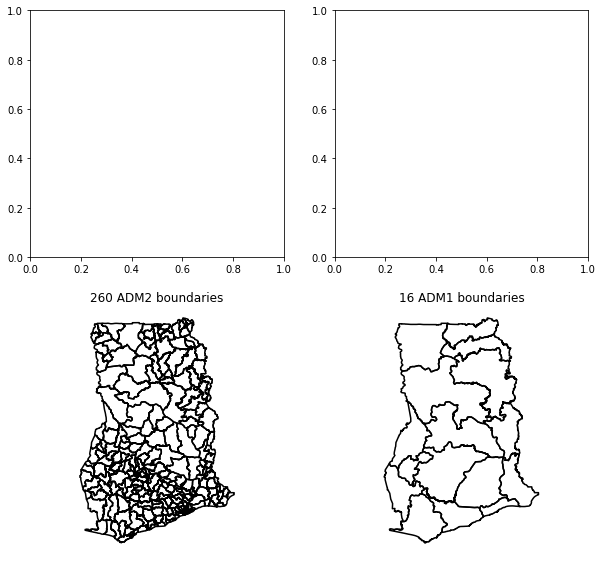

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
# geob4.boundary.plot(ax=ax[0, 0], color='black', linewidth=0.5).set_axis_off()
# ax[0, 0].set_title(f'{len(geob4)} ADM4 boundaries')
# geob3.boundary.plot(ax=ax[0, 1], color='black', linewidth=1).set_axis_off()
# ax[0, 1].set_title(f'{len(geob3)} ADM3 boundaries')
geob2.boundary.plot(ax=ax[1, 0], color='black').set_axis_off()
ax[1, 0].set_title(f'{len(geob2)} ADM2 boundaries')
geob1.boundary.plot(ax=ax[1, 1], color='black').set_axis_off()
ax[1, 1].set_title(f'{len(geob1)} ADM1 boundaries')
# plt.axis('off')

In [6]:
master_table = pd.read_csv(os.path.join(input_dir, "tom_formatted", "hierarchy", "tom_edited_ghana_collapsed.csv"), encoding='utf-8')

In [7]:
master_table.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5
0,Eastern,Abuakwa North,Kukurantumi,Esther Twum Maternity Home,Esther Twum Maternity Home
1,Eastern,Abuakwa North,Kukurantumi,Kukurantumi Apotosu,Kukurantumi Apotosu


In [8]:
len(master_table)

10564

In [9]:
print(f"Unique Level 2: {len(master_table.orgunitlevel2.unique())}")
print(f"Unique Level 3: {len(master_table.orgunitlevel3.unique())}")
print(f"Unique Level 4: {len(master_table.orgunitlevel4.unique())}")
print(f"Unique Level 5: {len(master_table.orgunitlevel5.unique())}")

Unique Level 2: 49
Unique Level 3: 482
Unique Level 4: 2487
Unique Level 5: 9060


In [10]:
print(f"Unique Geoboundaries Adm 1: {len(geob1)}")
print(f"Unique Geoboundaries Adm 2: {len(geob2)}")
#print(f"Unique Geoboundaries Adm 3: {len(geob3)}")
#print(f"Unique Geoboundaries Adm 4: {len(geob4)}")

Unique Geoboundaries Adm 1: 16
Unique Geoboundaries Adm 2: 260


## Match health list admin names to shapefile admin names
### Match orgunitlevel3 to geoboundaries Adm 2
Try using fuzzy matching  

In [11]:
level3_list = list(master_table.orgunitlevel3.unique())
level3_list.sort()
geob2_list = list(geob2.shapeName)
geob2_list.sort()

Print names one at a time for both datasets one letter at a time, and manually inspect

In [12]:
for letter in ascii_uppercase:
    level3_sublist = [name for name in level3_list if name[0]==letter]
    geob2_sublist = [name for name in geob2_list if name[0]==letter]

    if len(level3_sublist)>0:
        print("Master list level 3")
        print("\t"+str(level3_sublist))
    if len(geob2_sublist) >0:
        print("Geoboundaries adm2")
        print("\t"+str(geob2_sublist))
        
    print("\n")

Master list level 3
	['Abaam', 'Abamkrom', 'Abenase', 'Abenehease', 'Abetifi', 'Abiriw', 'Ablekuma Central', 'Ablekuma North', 'Ablekuma West', 'Aboabo', 'Abomasarefo', 'Abomosu', 'Abourso', 'Abuakwa North', 'Abuakwa South', 'Abura-Asebu-Kwamankese', 'Aburi', 'Accra Metro', 'Achiase', 'Ada East', 'Ada West', 'Adaklu', 'Adansi Akrofuom', 'Adansi Asokwa', 'Adansi North', 'Adansi South', 'Adawso', 'Adeiso', 'Adentan', 'Adjena Gyakiti', 'Adoagyiri', 'Aduasa', 'Adukrom', 'Adweso', 'Afadjato South', 'Afigya Kwabre North', 'Afigya Kwabre South', 'Afosu', 'Agavenya', 'Agogo (Eastern)', 'Agona East', 'Agona West', 'Agormanya', 'Agortime-Ziope', 'Agyata', 'Ahafo Ano North', 'Ahafo Ano South East', 'Ahafo Ano South West', 'Ahanta West', 'Ahomahomasu', 'Ajumako-Enyan-Essiam', 'Akanteng', 'Akateng', 'Akatsi North', 'Akatsi South', 'Akenkausu', 'Akim Swedru', 'Akoase', 'Akokoaso', 'Akorabo', 'Akosombo', 'Akote', 'Akrofufu', 'Akropong', 'Akropong (Eastern)', 'Akroso', 'Akuse', 'Akwadum', 'Akwamufie A

Manually adjust spellings of master health list to create more matches.

In [13]:
master_table.loc[:, "orgunitlevel3_edit"] = master_table.orgunitlevel3

In [14]:
# # master_table.loc[master_table.orgunitlevel4 == "Bo City", "orgunitlevel4_edit"] = "Bo Town"
# master_table.loc[master_table.orgunitlevel4 == "Central 1 Zone", "orgunitlevel4_edit"] = "Central I"
# master_table.loc[master_table.orgunitlevel4 == "Central 2 Zone", "orgunitlevel4_edit"] = "Central II"
# master_table.loc[master_table.orgunitlevel4 == "East 1 Zone", "orgunitlevel4_edit"] = "East I"
# master_table.loc[master_table.orgunitlevel4 == "East 2 Zone", "orgunitlevel4_edit"] = "East II"
# master_table.loc[master_table.orgunitlevel4 == "East 3 Zone", "orgunitlevel4_edit"] = "East III"
# master_table.loc[master_table.orgunitlevel4 == "West 1 Zone", "orgunitlevel4_edit"] = "West I"
# master_table.loc[master_table.orgunitlevel4 == "West 2 Zone", "orgunitlevel4_edit"] = "West II"
# master_table.loc[master_table.orgunitlevel4 == "West 3 Zone", "orgunitlevel4_edit"] = "West III"
# master_table.loc[master_table.orgunitlevel4 == "Bagbwe", "orgunitlevel4_edit"] = "Bagbwe(Bagbe)"

Remove key words that confuse matching algorithm

In [15]:
remove_words(master_table, "orgunitlevel3_edit", ['Town', 'City', 'Urban', 'Zone', 'Municipal'])
remove_words(geob2, "shapeName", ['Town', 'City', 'Urban', 'Zone', 'Municipal'])

In [16]:
# level4_list = list(master_table.orgunitlevel4.unique())
level3_list = list(master_table.orgunitlevel3_edit.unique())
level3_list.sort()
geob2_list = list(geob2.shapeName)
geob2_list.sort()

In [17]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over orgunitlevel4_edit list
for name in level3_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob2_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level2" : name})
    dict_.update({"name_geob2" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm2 = pd.DataFrame(dict_list)
table_adm2_matches = table_adm2[table_adm2.score >= 80].copy()

In [18]:
matches_pct = (len(table_adm2_matches) / len(level3_list))
'{:.2f}%'.format(matches_pct*100)

'51.87%'

In [19]:
# could save this list for someone to confirm matches manually
# for now take input noting which ones should be dropped based on quick inspection
table_adm2_matches.loc[table_adm2_matches.score<=80]

,name_level2,name_geob2,score
174,Bolgatanga East,Bolgatanga,80
259,Kadewaso,Kwadaso,80
481,Zongo,Bongo,80


In [20]:
# for idx, row in table_adm2_matches.loc[table_adm2_matches.score<=80].iterrows():
#     print(row)
#     print('\n')
    #drop_input = input("Drop? If no, leave blank: ")
#     if len(drop_input)>0:
#         table_adm2_matches.drop(idx, axis=0, inplace=True)

In [21]:
matches_pct = (len(table_adm2_matches) / len(level3_list))
'{:.2f}%'.format(matches_pct*100)

'51.87%'

### Match orgunitlevel2 to geo Adm 1

In [22]:
master_table.loc[:, "orgunitlevel2_edit"] = master_table.orgunitlevel2

In [23]:
# remove_words(geob2, "admin2Name", [" City Council", " District Council", " Municipal Council"])
remove_words(master_table, "orgunitlevel2_edit", [" District"])
remove_words(geob1, "shapeName", [" City Council", " District Council", " Municipal Council", "Region"])

In [24]:
level2_list = list(master_table.orgunitlevel2_edit.unique())
level2_list.sort()
geob1_list = list(geob1.shapeName)
geob1_list.sort()

Print names one at a time for both datasets one letter at a time, and manually inspect

In [25]:
for letter in ascii_uppercase:
    level2_sublist = [name for name in level2_list if name[0]==letter]
    geob1_sublist = [name for name in geob1_list if name[0]==letter]
    if len(level2_sublist)>0:
        print("Master list level 2")
        print("\t"+str(level2_sublist))
    if len(geob1_sublist) > 0:
        print("Geoboundaries adm1")
        print("\t"+str(geob1_sublist))
    print("\n")

Master list level 2
	['Abuakwa North', 'Abuakwa South', 'Achiase', 'Ahafo', 'Akwapim North', 'Akwapim South', 'Akyemansa', 'Asene Manso Akroso', 'Ashanti', 'Asuogyaman', 'Atiwa East', 'Atiwa West', 'Ayensuano']
Geoboundaries adm1
	['Ahafo', 'Ashanti']


Master list level 2
	['Birim Central', 'Birim North', 'Birim South', 'Bono', 'Bono East']
Geoboundaries adm1
	['Bono', 'Bono East']


Master list level 2
	['Central']
Geoboundaries adm1
	['Central']


Master list level 2
	['Denkyembour']


Master list level 2
	['Eastern']
Geoboundaries adm1
	['Eastern']


Master list level 2
	['Fanteakwa North', 'Fanteakwa South']


Master list level 2
	['Greater Accra']
Geoboundaries adm1
	['Greater Accra']








Master list level 2
	['Kwaebibirem', 'Kwahu Afram Plains North', 'Kwahu Afram Plains South', 'Kwahu East', 'Kwahu South', 'Kwahu West']


Master list level 2
	['Lower Manya-Krobo']




Master list level 2
	['New Juaben North', 'New Juaben South', 'North East', 'Northern', 'Nsawam-Adoagyiri']

In [26]:
# List for dicts for easy dataframe creation
dict_list = []

for name in level2_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob1_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level1" : name})
    dict_.update({"name_geob1" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm1 = pd.DataFrame(dict_list)
table_adm1_matches = table_adm1[table_adm1.score > 75]

In [27]:
matches_pct = (len(table_adm1_matches) / len(level2_list))
'{:.2f}%'.format(matches_pct*100)

'34.69%'

Loop through each row in master table, and add new attribute names (adm2 and adm1), if the names produced matches in the lookup tables

In [28]:
master_table_copy = master_table.copy()

In [29]:
master_table_copy

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel3_edit,orgunitlevel2_edit
0,Eastern,Abuakwa North,Kukurantumi,Esther Twum Maternity Home,Esther Twum Maternity Home,Kukurantumi,Abuakwa North
1,Eastern,Abuakwa North,Kukurantumi,Kukurantumi Apotosu,Kukurantumi Apotosu,Kukurantumi,Abuakwa North
2,Eastern,Abuakwa North,Kukurantumi,Kukurantumi,Kukurantumi,Kukurantumi,Abuakwa North
3,Eastern,Abuakwa North,Kukurantumi,Sokode Juaso,Sokode Juaso,Kukurantumi,Abuakwa North
4,Eastern,Abuakwa North,Kukurantumi,The Community Hospital (Kukurantumi),The Community Hospital (Kukurantumi),Kukurantumi,Abuakwa North
...,...,...,...,...,...,...,...
10559,Ghana,Western North,Suaman,Karlo,Karlo,Suaman,Western North
10560,Ghana,Western North,Suaman,Karlo,Kwabenakrom,Suaman,Western North
10561,Ghana,Western North,Suaman,Karlo,Sui-Ano,Suaman,Western North
10562,Ghana,Western North,Suaman,Kwasuo,Kwassuo,Suaman,Western North


In [30]:
for idx, row in master_table_copy.iterrows():
    
    if row.orgunitlevel3_edit in list(table_adm2_matches.name_level2):
        
        match = table_adm2_matches.loc[table_adm2_matches.name_level2==row.orgunitlevel3_edit, "name_geob2"].iloc[0]
        master_table_copy.loc[idx, 'adm2'] = match
        
    if row.orgunitlevel2_edit in list(table_adm1_matches.name_level1):
        
        match = table_adm1_matches.loc[table_adm1_matches.name_level1==row.orgunitlevel2_edit, "name_geob1"].iloc[0]
        master_table_copy.loc[idx, 'adm1'] = match

In [31]:
master_table_copy.adm2.isna().sum()

1774

In [32]:
master_table_copy.adm1.isna().sum()

1108

In [33]:
master_table_copy.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel3_edit,orgunitlevel2_edit,adm2,adm1
0,Eastern,Abuakwa North,Kukurantumi,Esther Twum Maternity Home,Esther Twum Maternity Home,Kukurantumi,Abuakwa North,NaN,NaN
1,Eastern,Abuakwa North,Kukurantumi,Kukurantumi Apotosu,Kukurantumi Apotosu,Kukurantumi,Abuakwa North,NaN,NaN


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.  
In QGIS, I created centroids from the ways then merged it with the points.

In [34]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", "GHA", "merged_GHA_healthsites.shp"))

In [35]:
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()

In [36]:
nodes_io['name'] = nodes_io['name'].str.lower()

In [37]:
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 
                   'health', 'government', 'maternity', 'home', 'cabinet', 'medical']

In [38]:
records = master_table_copy.copy()
records['NAME'] = records['orgunitlevel5'].str.lower()

In [39]:
remove_words(nodes_io, 'name', words_to_remove)
remove_words(records, 'NAME', words_to_remove)

In [40]:
records['geocoding_method'] = "None"

In [41]:
for idx, row in tqdm(records.iterrows()):
    
    # Check if there is another entry with location
    match, score = match_name(row.NAME, list(nodes_io['name']), 80)
#     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)
    
    if score > 0:
        print(row.NAME, match)
        matching_row = nodes_io.loc[nodes_io['name']==match].copy()
        res = matching_row.iloc[0]
        
        geocoded=False
        if not pd.isna(row.adm2):
            adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
            if adm2.contains(res.geometry).values[0] == True:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 2"
                geocoded=True
        
        if (geocoded==False) and (not pd.isna(row.adm1)):
            adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy()
            if adm1.contains(res.geometry).values[0] == True:            
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 1"
                geocoded=True
                
        if geocoded==False:
            records.loc[idx, "longitude"] = res.geometry.x
            records.loc[idx, "latitude"] = res.geometry.y
            records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and without admin verification"

44it [00:00, 212.19it/s]

anyinasin nyinahin
new tafo new tafo
kibi kibi


88it [00:00, 213.04it/s]

achiase achiase
lab labs
adawso adweso
obosomase bodomase


200it [00:00, 216.29it/s]

anyinase aiyinase
emmauel . emmanuel
st theresa st. theresia
eshiem esidem


244it [00:01, 218.04it/s]

adjena adenta
adjena adenta
boso aboso
boso aboso


311it [00:01, 220.22it/s]

mampong mampong
new jejeti new jejeti


357it [00:01, 214.61it/s]

otoase abotoase
essam essiama
epl epcl
oda oda
oda oda


424it [00:01, 215.72it/s]

okaikrom kwamikrom
oforikrom kofikrom
st dominic st.dominic
boadua bodada
abourso

470it [00:02, 219.67it/s]

 aburaso
nkankama nkwankwaa


561it [00:02, 222.68it/s]

holy rosary holy rosary
asanyanso asanyansu


607it [00:02, 220.19it/s]

fosu osu
ankoma anoma


653it [00:02, 220.49it/s]

asakraka asakraka
atibie atibie
adawso adweso


721it [00:03, 216.72it/s]

kenop care kenop care
agyakwa agyakwa
akuse akuse
adome adidome
kpong kpongka


788it [00:03, 216.76it/s]

atua atua
atua atua
mampong mampong
asaman amasaman


831it [00:03, 206.80it/s]

adweso adweso
adweso adweso
anglican anglican
dr. asomani dr asomani
providence providence
koforidua poly koforidua poly
oman oman
eastern regional eastern regional
tanoso tanoso
cosmos/damien cosmas- damien
koforidua koforidua
koforidua sda koforidua


921it [00:04, 217.51it/s]

newlands newlands
abonse labone
providence providence


987it [00:04, 214.25it/s]

okanta okanta
suhum suhum
sawa sawia
asesewa asesewa
asesewa asesewa


1032it [00:04, 216.51it/s]

kumikrom kwamikrom
adeiso adeiso


1101it [00:05, 219.49it/s]

anum-asaman amasaman
akpo vakpo
wurapong dawurampong


1169it [00:05, 216.90it/s]

akrodie akrodie
cross care cross care
goaso municipal goaso municipal
ahmadiyya muslim ahmadiyya muslim
life care life  care


1235it [00:05, 206.74it/s]

star of hope star of hope
achiase achiase
cross care cross care


1302it [00:06, 209.99it/s]

apenemadi  compound apenamadi chips compound
mankranho mankranso
bomaa district bole district


1345it [00:06, 204.53it/s]

bechem bechem
mansin  compound mansion chips compound
st. joseph st. joseph's
adaa  compound adaa chps compound
asuboe  compound asuboi chips compound
anomabo anoma


1389it [00:06, 209.54it/s]

anhwiaso ahwiaso


1456it [00:06, 211.17it/s]

aburaso aburaso
amudurase samudure
fountain enclave fountain care
ashan ashan


1523it [00:07, 205.96it/s]

bomso bomso
kodie akrodie
anyinasuso anyinasuso
anyinasuso anyinasuso


1589it [00:07, 193.68it/s]

st. edwards st. edward's
abesewa asesewa
mankranso mankranso
mankranso mankranso
nyameadom nyameadom
achiase achiase


1648it [00:07, 182.82it/s]

hia shia
abuakwaa abuakwa
abuakwaa abuakwa
kofihwikrom kofikrom


1690it [00:07, 193.52it/s]

achiase achiase
abuoso aboso


1734it [00:08, 205.55it/s]

mother of god mother of god
graham memorial grace memorial


1824it [00:08, 216.22it/s]

dampong darpong
koikrom kofikrom


1914it [00:09, 219.27it/s]

mampong mampong


1959it [00:09, 213.58it/s]

providence providence
garden city garden city
roman catholic roman catholic


2025it [00:09, 206.41it/s]

garry marvin memorial gary marvin memorial
maba mba
samel samsel
aburaso aburaso
trinity specialist trust specialist


2067it [00:09, 195.79it/s]

anglican anglican
kotokuom kotoku
achiase achiase
mother of john mother of god
nyinahin nyinahin
abuakwa abuakwa
madonna  services dons  services


2127it [00:10, 196.10it/s]

asakrakra asakraka
frimpong boateng frimpong boateng
mount sinai mount sinai
achiase achiase
ahwene memorial ahwenie memorial


2170it [00:10, 202.33it/s]

bekwai municipal bekwai municipal
bodoma bodomase
akomaah memorial amoah memorial


2212it [00:10, 202.39it/s]

adeito adeiso
richard fowle catholic richard fowler catholic
anyinase aiyinase


2325it [00:11, 214.83it/s]

sanford sanford
kwaso nkwaeso
st. anthony anns st. anthony's
st. anthony st. anthony's


2370it [00:11, 213.23it/s]

2437it [00:11, 205.57it/s]

new koforidua koforidua
atasamanso atasomanso
atasomanso atasomanso
asafo agyei asafo agyei
champion divine champion divine
new cross new cross


2480it [00:11, 203.24it/s]

metro metro
suntreso suntreso
abrafi memorial armah memorial
presby presby
three stones three stone


2522it [00:11, 201.11it/s]

mater dei mater dei
west end west end
komfo anokye teaching komfo anokye teaching


2565it [00:12, 203.67it/s]

aboaso aboso
zion praise zion praise


2610it [00:12, 204.53it/s]

mamponteng mampong
mamponteng mampong
hope xchange hopexchange
tiwaa memorial war memorial
ruma specialist trust specialist
tanoso tanoso
tanoso tanoso


2675it [00:12, 204.89it/s]

st. john's st. joseph's
brahabebome brahabebome
emmanuel emmanuel


2718it [00:12, 203.39it/s]

twumwaa twumasiwaa
koforidua koforidua
anyinasuso sda anyinasuso
offinso offinso
akumadan akumadan


2782it [00:13, 199.06it/s]

nkwakwaa nkwankwaa
nkwankwaa nkwankwaa
mankramso mankranso
nkenkaasu nkenkaasu
florence florence
ayeduase ayeduase
ayeduase ayeduase


2823it [00:13, 185.49it/s]

bomso bomso
bomso bomso
adabraka adabraka
amoah memorial amoah memorial
holy rosary holy rosary
power house power house
omar omari
tafo tafo
central   annex central kasoa  - annex
nizon memorial anthon memorial
santan santa


2935it [00:14, 210.09it/s]

nkwankwaanua nkwankwaa
westphalian westphalian
bodomase bodomase


3002it [00:14, 214.08it/s]

bedomase bodomase
kofikrom kofikrom


3046it [00:14, 206.57it/s]

ayiwa memorial war memorial
ppag suame ppag suame
anomangye specialty anomangye specialist
kropo charity kropo charity
tarkwa tarkwa
boase daboase


3113it [00:14, 206.44it/s]

takoradi takoradi
dormaa east district ada east district
amasu ahamasu


3203it [00:15, 215.86it/s]

dormaa west district ada east district
fountain care fountain care


3248it [00:15, 218.46it/s]

atuna atua


3317it [00:15, 219.58it/s]

atronie atronie
atronie atronie
atoase abotoase


3360it [00:16, 206.00it/s]

lane lane
opoku opoku
sunyani municipal hosp sunyani municipal
jamesbert jamesbert
cross care cross care
agyinasie aiyinase


3402it [00:16, 200.82it/s]

addoe adidome
st. anthony's st. anthony's
tainso tanoso
yabraso aburaso


3465it [00:16, 193.92it/s]

st. joseph st. joseph's
boadan bodada
emil memorial ami memorial
wenchi enchi
wenchi enchi


3532it [00:16, 209.65it/s]

fakwesi fakwasi
kintampo municipal keta municipal


3599it [00:17, 208.38it/s]

dumso bethel dumso bethel chps
kintampo south district kintampo south district
amoako care city amoako  city


3706it [00:17, 208.45it/s]

our lady of fatima  care our lady of fatima


3773it [00:18, 211.83it/s]

nkwaeso nkwaeso
amoako  city amoako  city
bongroso bogoso


3817it [00:18, 213.58it/s]

abrefi women and children abrafi women and children
krobo memorial otoo memorial


3862it [00:18, 209.08it/s]

abaka abuakwa
tuakwa tarkwa
nyamedom nyameadom
aggrey memorial grace memorial
moree moree


3950it [00:18, 212.87it/s]

ahamadiyya ahmadiyya
st joseph st. joseph's
essaman essiama
yeboah yeboah


3994it [00:19, 208.56it/s]

ayinasu anyinasuso
abaka abuakwa
bosomase bodomase


4060it [00:19, 211.32it/s]

abesewa asesewa
our lady of fatima our lady of fatima
achiano chirano


4127it [00:19, 215.21it/s]

achiase achiase
providence  & providence


4192it [00:20, 205.26it/s]

justab justab
mother and child ssnit mother and child
bethel bethel
holy family holy family
justab justab


4235it [00:20, 204.55it/s]

abura abura
cape coast teaching cape coast teaching
dis dis
tantri tantri
wghs ghs
ola nola


4277it [00:20, 194.61it/s]

university university
gyangyanadze gyangyazie
university university
winneba municipal wa municipal
bethel bethel
otoo memorial otoo memorial
akwakrom kwamikrom
ebuakwa abuakwa


4319it [00:20, 197.88it/s]

narkwa tarkwa
aboso aboso
ekwamkrom kwamikrom
st gregory catholic st. gregory catholic


4361it [00:20, 201.15it/s]

nadom nandom
roman trust roman trust
nsuekyir nsuakyire
debiso adeiso
eshiem esidem


4403it [00:21, 195.97it/s]

tarkwa tarkwa
dawurampong poly dawurampong
abooso aboso
elmina poly madina poly
good shepherd royal good shepherd


4446it [00:21, 202.75it/s]

komenda komenda
anomabo anoma
peace peace
st anthony st. anthony's


4510it [00:21, 202.56it/s]

abodom  compound abodom chps compound
mampong mampong
st florence st florence
achiase achiase
dunkwa municipal wa municipal


4553it [00:21, 204.56it/s]

st mark st. mark
pentecost pentecost
sda sda


4619it [00:22, 211.60it/s]

anyinasin nyinahin
new tafo new tafo
kibi kibi


4663it [00:22, 208.81it/s]

achiase achiase
lab labs
adawso adweso


4708it [00:22, 215.08it/s]

obosomase bodomase


4753it [00:22, 216.80it/s]

anyinase aiyinase
st theresa st. theresia


4797it [00:22, 209.64it/s]

eshiem esidem
adjena adenta
adjena adenta
boso aboso


4841it [00:23, 208.03it/s]

boso aboso
mampong mampong
new jejeti new jejeti


4929it [00:23, 206.53it/s]

otoase abotoase
essam essiama
epl epcl
oda oda
oda oda


4972it [00:23, 205.77it/s]

okaikrom kwamikrom
oforikrom kofikrom
st dominic st.dominic
boadua bodada


5016it [00:24, 211.04it/s]

abourso aburaso
nkankama nkwankwaa


5107it [00:24, 219.71it/s]

holy rosary holy rosary
asanyanso asanyansu


5174it [00:24, 214.78it/s]

fosu osu
ankoma anoma


5218it [00:24, 211.92it/s]

asakraka asakraka
atibie atibie
adawso adweso


5285it [00:25, 214.49it/s]

kenop care kenop care
agyakwa agyakwa
akuse akuse
adome adidome
kpong kpongka


5329it [00:25, 208.83it/s]

atua atua
atua atua
mampong mampong
asaman amasaman


5373it [00:25, 203.84it/s]

adweso adweso
adweso adweso
anglican anglican
dr. asomani dr asomani
koforidua poly koforidua poly
eastern regional eastern regional
tanoso tanoso
cosmos/damien cosmas- damien
koforidua koforidua
koforidua sda koforidua


5417it [00:25, 201.29it/s]

newlands newlands


5484it [00:26, 211.03it/s]

abonse labone
providence providence


5528it [00:26, 209.13it/s]

okanta okanta
suhum suhum
sawa sawia
asesewa asesewa
asesewa asesewa


5595it [00:26, 216.98it/s]

adeiso adeiso


5662it [00:27, 213.43it/s]

anum-asaman amasaman
akpo vakpo
wurapong dawurampong


5729it [00:27, 208.35it/s]

barnor barnor
new cross new cross
fred pharmacy edpa pharmacy


5771it [00:27, 198.13it/s]

hanson memorial anthon memorial
family family
dansoman poly dansoman poly
nyame adom nyameadom
nyame adom nyameadom


5811it [00:27, 198.90it/s]

adwoa boatema memorial adowa boatemaa memorial
faith evangelical mission faith evangelical mission
korle-bu teaching korle bu teaching
mamprobi mamprobi
university of ghana  school university of ghana


5855it [00:28, 207.00it/s]

club road club road


5899it [00:28, 203.78it/s]

cocoa cocoa
hobats hobats
kaneshie poly kaneshie poly
love lover
ada  east district ada east district


5988it [00:28, 208.97it/s]

adenta adenta
mother love mother love
mother-love mother love
st. john of god st. john of god


6032it [00:28, 197.51it/s]

hag hag
rinat rinat
marie stopes marie stopes
middle east middle east
st. bernard st. bernhard eye
st mina st. mina
st. mina st. mina
general family general family


6074it [00:29, 200.99it/s]

afenyo memorial afenyo memorial
okanta okanta
mother of god mother of god
nyame adom nyameadom


6116it [00:29, 199.34it/s]

mother love mother love
ashaiman poly ashaiman poly
darbem dar-bem
st florence st florence
anthon memorial anthon memorial


6157it [00:29, 194.23it/s]

anthon memorial  annex anthon memorial
effan victory efan victory
37 military 37 military
gbc gbc
gbc gbc
new cross new cross
redeem redeemer


6198it [00:29, 192.87it/s]

zak med zak-med
maamobi general mamobi general
acacia acacia
bemuah royal bemuah royal
emmanuel eye emmanuel eye
mchenlys mchenly's
obaatan pa women's obaatan pa womens
quality care quality care
save the nation's sight save the nation's sight


6238it [00:29, 181.98it/s]

university of ghana university of ghana
yeboah yeboah
airport women's airport womens
claron  international claron  international
net net
nyaho nyaho
dr amoah memorial amoah memorial


6304it [00:30, 197.60it/s]

walmart calmart
agbogba agbogba
ashongman 1 ashongman
ashongman 2 ashongman
 


6344it [00:30, 182.95it/s]

van vane
faith faith
otobea memorial otoo memorial
penbrose penbrose
agbogba agbogba
ashongman ashongman
cedar cedars
classic diagnostic and classic diagnostic &
ga east municipal goaso municipal
ghana atomic energy commission ghana atomic energy commission
sam j sam j


6430it [00:30, 195.18it/s]

st. moses st moses
bj bj
providence specialist provident specialist
tantra tantri
accra west accra west
all faith all faith
 


6494it [00:31, 189.83it/s]

amasaman amasaman
ga west municipal goaso municipal
edith edith's
kotoku kotoku
kotoku kotoku
kotoku kotoku
medie medline
samsam samsam


6536it [00:31, 187.64it/s]

adabraka poly adabraka poly
odorna odorna
odorna odorna
dua dua
iran iran
divine divine
osu osu
civil service civil service poly
c & j medicare c&j medicare


6577it [00:31, 189.01it/s]

nyaho nyaho
sic bob freeman sic bob freeman
katamanso atasomanso
katamanso atasomanso
all care all care
atlantis atlantis
darkwa memorial armah memorial


6616it [00:31, 185.52it/s]

faith faith
nanoman anoma
valley view university valley view university
general family general family
lebanon lebanon


6657it [00:32, 193.04it/s]

crossroad crossroad
danpong darpong
efan victory efan victory
lekma poly tema poly
aboso aboso
solice police


6698it [00:32, 195.17it/s]

akai house akai house
la general la general
danfa danfa
divine divine
greater grace greater grace
pantang pantang


6738it [00:32, 190.89it/s]

pantang pantang
pentecost pentecost
vision vision
esidem esidem
pentecost pentecost
north legon north legon
presby presby


6779it [00:32, 183.27it/s]

lekma lekma
lister lister
manna mission manna mission
bengazi bengali
family family
oak street the oak street
afienya afienya
eastwing eastwing
omari omari


6861it [00:33, 192.68it/s]

emmanuel emmanuel
opman opmann
achimota achimota
al ayar al-ayar
al- ayar al-ayar


6923it [00:33, 196.74it/s]

meridian meridian
port port
bethel bethel
caiquo caiquo
narh-bita narh-bita
tema new crystal new crystal
bengali bengali
rapha raphal


6963it [00:33, 187.29it/s]

tema general tema general
tema women tema women's
valco valco
new crystal new crystal
king david king david
international maritime international opatic
maldey maldey
tema poly tema poly


7023it [00:34, 192.32it/s]

jubail specialist jubail specialist
sakumono sakumono
sakumono sakumono
dora memorial grace memorial
oblogo oblogo
royal good shepherd royal good shepherd


7067it [00:34, 203.71it/s]

weija-gbawe municipal weija-gbawe municipal
faith faith
famisah amiah


7110it [00:34, 205.26it/s]

divine divine
baptist baptist
divine divine
namoo namoo


7152it [00:34, 201.50it/s]

janga poly janga poly
janga rch janga chps
kpasenkpe kpasinkpe
catholic family reproductive  project catholic family reproductive  program
st. patrick's st patrick
namongo namolgo


7195it [00:34, 204.37it/s]

gushiegu gushiegu
kpatinga kpatia
karaga district lawra district
bagurugu bagurugu


7239it [00:35, 207.60it/s]

pishigu pishigu


7330it [00:35, 219.93it/s]

kpabia kpatia
bimbilla  district zebilla district
pusugu pusupu


7421it [00:35, 220.53it/s]

yashfah  services faith  services
fulera fulera
gurugu bagurugu


7465it [00:36, 207.12it/s]

tamale technical university tamale technical university
god cares god cares
tania specialist tizaa specialist
emmanuel refuge emmanuel eye
fuo fuo
fuo fuo


7507it [00:36, 202.02it/s]

diare diare
kpong kpongka
savelugu district savelugu district
rabito rabito


7550it [00:36, 203.32it/s]

tamale teaching tamale teaching
tamale west tamale west
kabsad scientific kabsad scientific


7594it [00:36, 211.31it/s]

nyankpala sankpala
yendi yendi


7660it [00:37, 214.73it/s]

abotoase abotoase
kwamikrom kwamikrom
worawora worawora
atonkor atorkor
bodada bodada


7703it [00:37, 192.29it/s]

jasikan district jasikan district
ahamansu ahamasu
ahamansu ahamasu
kponkpa kpongka
poase cement poase cement
poase cement poase cement
st. mary theresa st mary theresa
bethel bethel


7742it [00:37, 183.79it/s]

faith faith
kadjebi kedjebi
okanta okanta
asukawkaw asukawkaw


7807it [00:37, 201.36it/s]

yariga nyariga
st luke st. lukes


7850it [00:38, 206.31it/s]

kpassa kpassa
kpassa kpassa
pusupu pusupu
nkwanta municipal nkwanta south municipal


7894it [00:38, 211.12it/s]

bole district bole district
sankpala sankpala


7983it [00:38, 206.71it/s]

presby presby
salaga district lawra district
sakpalua sankpala


8050it [00:38, 210.99it/s]

busunu busunu
larabanga larabanga


8165it [00:39, 216.78it/s]

atuba atua
pologo oblogo
zuarungu zuarungu


8231it [00:39, 210.22it/s]

nyariga nyariga
afrikids - afrikids
amiah amiah
presby presby


8275it [00:40, 212.15it/s]

dua dua
namoo namoo


8320it [00:40, 212.74it/s]

nyariga nyariga
st. theresah st. theresia


8387it [00:40, 214.98it/s]

garu garu
kpatua kpatia
kologo oblogo


8432it [00:40, 216.59it/s]

war memorial war memorial


8500it [00:41, 212.58it/s]

gwaru garu
busungu busunu
ayamfoya memorial amoah memorial
salifu memorial ami memorial


8544it [00:41, 209.51it/s]

nakom nako
yariga nyariga
namolgo namolgo
shia shia


8587it [00:41, 206.96it/s]

talensi district talensi district
kongo konongo
rabito rabito


8654it [00:41, 209.66it/s]

hain poly ashaiman poly
st. joseph's st. joseph's


8767it [00:42, 216.02it/s]

furo fuo
jang jaang


8859it [00:42, 217.95it/s]

good shepherd royal good shepherd
nandom nandom


8996it [00:43, 211.94it/s]

st. john's st. joseph's
katua atua
chasia charia
charia charia


9063it [00:43, 214.77it/s]

wa municipal wa municipal
poyentanga ponyentanga


9107it [00:43, 209.62it/s]

wa west district ada east district
have have
have have


9175it [00:44, 216.20it/s]

akatsi district akatsi district
atorkor atorkor


9265it [00:44, 207.53it/s]

duga dua
forsight foresight
ho municipal ho municipal
ho technical university tamale technical university
volta regional volta regional
shia shia


9307it [00:44, 197.36it/s]

gisela memorial nagel memorial
ameco ameco
vane vane
kpedze  poly kpedze poly
tsibu tsibu
dzolokpuita dzolopuita
st. francis st francis


9372it [00:45, 207.14it/s]

hohoe municipal hohoe municipal
likpe bakua poly likpe bakua poly
keta municipal keta municipal


9439it [00:45, 208.61it/s]

central aflao central aflao
ketu south district ketu south district
new hope new hope
sape agbo memorial sape agbo memorial
margret marquart catholic margret marquart catholic


9502it [00:45, 204.16it/s]

torkor atorkor
anfoega catholic anfoega catholic
botoku kotoku
vakpo vakpo


9570it [00:46, 211.49it/s]

kpeve newtown kpeve new town
wegbe kpalime wegbe kpalime
peki peki


9614it [00:46, 207.32it/s]

comboni comboni
sogakope district sogakope district
abura abura
abura abura


9681it [00:46, 209.74it/s]

family family
new crystal new crystal
takoradi technical university tamale technical university
aiyinase aiyinase


9746it [00:46, 205.56it/s]

asanta santa
esiama essiama
kwasikrom kwamikrom
elubo elubo
frontier frontier
half assini half-assini


9789it [00:47, 208.41it/s]

nzema baptist nzema baptist
our lady of fatima our lady of fatima


9853it [00:47, 204.93it/s]

aboso aboso
bogoso bogoso
bogoso bogoso
st edward st. edward's


9918it [00:47, 204.55it/s]

effia nkwanta regional effia nkwanta regional
madamfo specialist madamfo specialist
sanford sanford
stratford stanford
nagel memorial  sda nagel memorial
st francis st francis


9960it [00:48, 192.37it/s]

dis dis
international sos international mission
port port
tadi high street takoradi high street
takoradi takoradi
twin city twin city
vra vra
shama shama


10002it [00:48, 191.74it/s]

anyinase aiyinase
sam jonna sam jonah
tebrebe tebrebe
divine divine
gmc gmc
ami memorial ami memorial
brahabobom brahabebome


10063it [00:48, 189.08it/s]

rabboni christian rabboni christian
redeemer redeemer
tarkwa tarkwa
tarkwa municipal wa municipal
umat umat
daboase daboase
kofiekrom kofikrom


10126it [00:48, 197.28it/s]

st. mark st. mark
wassa akropong govt wassa akropong
dawurampong dawurampong
bibianiha bibiani
afiena afienya


10171it [00:49, 205.81it/s]

father thomas alan rooney memorial father thomas allan rooney memorial
samartex samartex
wassa dunkwa wassa dunkwa


10236it [00:49, 209.88it/s]

nsadweso adweso
daboase daboase


10280it [00:49, 208.81it/s]

enchi enchi
bongoso bogoso
yonkofa yonkofa


10323it [00:49, 207.54it/s]

oforikrom kofikrom
essam essiama
kwamebikrom kwamikrom


10367it [00:50, 207.24it/s]

anhwiaso ahwiaso
debiso adeiso
green shield green shed
sefwi bekwai sefwi bekwai
daks daks


10409it [00:50, 199.88it/s]

divine love divine love
kwamekrom kwamikrom
anyinase aiyinase
chirano chirano


10453it [00:50, 198.06it/s]

yeboah's yeboah
topman opmann
juaboso aboso
kwawkrom kwamikrom
eluibo elubo
santase santa
benchema bechem


10516it [00:50, 204.13it/s]

kofikrom kofikrom
divine divine


10564it [00:51, 207.13it/s]

greenshield greenfield
tanoso tanoso
paboase daboase


In [42]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,144,1.4%
Location from Health Sites IO and within admin 2,273,2.6%
Location from Health Sites IO and without admin verification,343,3.2%
None,9804,92.8%


## RHINoVision Master Facility List Decision Support System

In [43]:
#rhino = pd.read_excel(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).xlsx"), 0)
rhino = pd.read_csv(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).csv"))

In [44]:
rhino = rhino.loc[rhino.Country=="Ghana"].copy()

In [45]:
rhino['name'] = rhino['Facility name'].str.lower()

In [46]:
remove_words(rhino, 'name')

In [47]:
rhino.loc[:, "geometry"] = rhino.apply(lambda x: Point(x.Long, x.Lat), axis=1)
rhino = gpd.GeoDataFrame(rhino, geometry='geometry', crs='EPSG:4326')

In [48]:
for idx, row in tqdm(records.iterrows()):
    
    if row.geocoding_method=="None":
        
        # Check if there is another entry with location
        match, score = match_name(row.NAME, list(rhino['name']), 80)

        if score > 0:
            print(row.NAME, match)
            matching_row = rhino.loc[rhino['name']==match].copy()
            res = matching_row.iloc[0]

            geocoded=False
            if not pd.isna(row.adm2):
                adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
                if adm2.contains(res.geometry).values[0] == True:
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset and within admin 3"
                    records.loc[idx, "source"] = res["LL source"]
                    geocoded=True

            if (geocoded==False) and (not pd.isna(row.adm1)):
                adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy()
                if adm1.contains(res.geometry).values[0] == True:            
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset and within admin 2"
                    records.loc[idx, "source"] = res["LL source"]
                    geocoded=True

            if geocoded==False:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset without admin verification"
                records.loc[idx, "source"] = res["LL source"]
            

35it [00:00, 175.45it/s]

asiedukrom adukrom
mangoase mangoase
akokoo akokoa
apedwa apedwa
adukrom adukrom
asiakwa asiakwa
sos isos


88it [00:00, 171.89it/s]

bomponso oponso
akenkensu akenkenso
anamase adamase
aperade aprade
anyinam anyinam
aboabo aboabo
kwamoso kwaso
akropong akropong


123it [00:00, 171.76it/s]

larteh larteh
besease bisease
tetteh quarshie memorial tetteh quarshie memorial district
amanfo manfo
kom kom
berekuso bereku


155it [00:00, 161.35it/s]

kitase kitare
abaase abease
pakro pakro
pokrom pokukrom
abenase abease
gyaha gyaha
adwafo edwafo
akokoaso akokuaso


188it [00:01, 160.72it/s]

ayirebi ayirebi
odumase odumase
brenase brenase
akyekrom anyekrom
akroso akroso
akroso akroso
asuboa asuboi
onomabo anomabo


225it [00:01, 171.87it/s]

badukrom adukrom
manso manso
manso manso
odumase odumase
aboasa aboaso
akwamufie akwamufie
akwamufie akwamufie


280it [00:01, 173.60it/s]

asikuma salvation army baa salvation army
new akrade new takoradi
anyinam anyinam


316it [00:01, 168.60it/s]

abekwase abease
sekyere sekyere
abomosu abomosu
akrofufu akrofu
bomaa bomaa
aboabo aboabo
asuboi asuboi
mankrong mankrong


354it [00:02, 176.70it/s]

achiansa chiana
aboabo aboabo
mawuli / quarters gulbi  quarters


390it [00:02, 172.83it/s]

bramkrom kramokrom
mamanso manso
abodom abodom
kuntunase akutuase
st michaels st. micheal
tweapease tweapease


427it [00:02, 174.48it/s]

akwatia nkwatia
awusua wusuta
domeabra domeabra
sadams adamsu
dwenease dwease
takrowase takrowase
dominase dominase


480it [00:02, 165.37it/s]

obuase obuasi
abaase abease
begoro salvation army baa salvation army
bontrase bontrase
bosuso bosuso
bepoase bepoase
ame zion a.m.e zion
nsutam nsuta
abodom abodom


514it [00:03, 163.72it/s]

asuom asuom
pramkese pramkese
subi subin
abenaso benso
mpeasem mempeasem
techiman techimantia
supom supomu


566it [00:03, 166.47it/s]

adukrom adukrom
kayera mayera
abotanso aboaso


603it [00:03, 167.90it/s]

bumpata bompata
forifori fofori
samanhyia manhyia
tease central tamale central
tease tease


639it [00:03, 169.57it/s]

bonkrase bontrase
nkwatia nkwatia
pepease pepease
bepong bepong
besease bisease
kwahu praso presby kwahu praso presby
sukwa sunkwa


673it [00:03, 166.70it/s]

mpraeso praso
obo obo
obomeng obomeng
nkyenenkyene nkyenekyene
kwahu jejeti kwahu jejeti


727it [00:04, 170.13it/s]

nkawkaw nsawkaw
ampekrom ampenkro
wawase wamase
abanse abease
akutue akutuase
salom shalom


766it [00:04, 181.14it/s]

oborpa obopa
damang damakung


808it [00:04, 188.21it/s]

jumapo jumapo
abotanso aboaso
densuano densuoano
nyamekrom nyakrom


869it [00:05, 185.33it/s]

adoagyiri adoagire
new life new life
notre dame notre dame


925it [00:05, 170.72it/s]

abiriw abiriw
abiriw abiriw
adukrom adukrom
kwamanteng amanteng
amanfro manfo
okrakwadjo okrakwadwo
okrakwadjo okrakwadwo
suhum district suhum  district


962it [00:05, 174.25it/s]

kukua kuka
amanhyia manhyia


1002it [00:05, 174.53it/s]

bormase borae
sekesua sekesua
abesre abease
amonkrom kramokrom
tiokrom tikrom


1056it [00:06, 167.54it/s]

kofi asare kofiase
akanteng amanteng
krofofrom akrofrom
abaase abease
brekumanso brekumanso


1091it [00:06, 162.99it/s]

topease tease
aprampramu prampram
osenase osenase
osuboi asuboi


1144it [00:06, 162.27it/s]

labolabo aboabo
ogome torgome
somanya somanya


1178it [00:06, 156.56it/s]

anyimaye anyinamae
gyasikrom - gyasikrom
abotanso aboaso
ampenkro ampenkro
church of pentecost church of pentecost
dominase dominase
bediako betiako


1210it [00:07, 153.55it/s]

abuom trabuom
beposo beposo
sankore sankore
biaso bisaaso


1246it [00:07, 161.58it/s]

gyedu gyedu
ntotroso ntobroso
kenyasi kenyasi
acherensua acherensua
beposo beposo


1281it [00:07, 158.51it/s]

dadiesoaba dadiesoaba
sienchem rural sienkyemu rural
sunkwa sunkwa
nkaseim nkasiem
subreso subriso


1337it [00:07, 169.48it/s]

derma derma
subriso subriso
techimantia techimantia
techimantia poly techimantia
tweapease tweapease
akrofuom akrofrom
nkoransa nkoranza
sikaman sikaman
adamso adamsu
ampunyase ampunyasi
ampunyase ampunyasi
wamasi jamasi
aboabo aboabo


1372it [00:08, 154.17it/s]

aboabo1 aboabo
fumso ketewa fumso-ketewa
asokwa asokwa
asokwa asokwa
nyamekrom nyakrom
fumso fumso
fumso fumso


1403it [00:08, 146.20it/s]

akrokerri akrokerri
akrokerrifie akrokerri
fomena fomena
fomena fomena
kyekyewere kyekyewere
patakro pakro
akutreso akutreso
akutreso akutreso
subriso subriso


1433it [00:08, 140.87it/s]

ataase ataasi
edwenase dwease
kramokrom kramokrom
nkranfo nkwanta nkrankwanta
praso praso
asamanya amanya
ahenkro ahenkro
ahenkro ahenkro


1463it [00:08, 139.02it/s]

kwamang kwamang
abroma abromase
adukro adukrom
boamang boamang
boamang boamang
akom kom
denase dwease
banko banko
tetrem tetrem
aboabogya aboabogya
aboabogya aboabogya
wawase wamase


1491it [00:09, 133.36it/s]

afrancho afrancho
krobo krobo
kyekyere kyekyewere
ankaase kaase
ejuratia ejuratia
methodist faith healing methodist faith healing district
brofoyedru brofoyedru


1526it [00:09, 150.09it/s]

aduman oduman
betiako betiako
betiako betiako
ankaase kaase
achina chiana
manfo manfo


1558it [00:09, 144.05it/s]

manfo manfo
odumase odumase
subriso subriso
subriso subriso
beposo beposo


1606it [00:09, 146.75it/s]

biemso biemso
domeabra domeabra
essienkyem essienkyem
nsuta nsuta
pokukrom pokukrom
pokukrom pokukrom
adukrom adukrom
sabronum sabronum
sabronum sabronum
mpasaso mpasaso
mpasaso mpasaso
anitemfe anitemfe


1622it [00:09, 136.98it/s]

domeabra domeabra
st. johns st. johns
wioso wioso
wioso wioso
mile 14 mile 14
mile 14 mile 14
mile 18 mile 14
akrofrom akrofrom


1673it [00:10, 148.70it/s]

krofrom akrofrom
numereso numereso
numereso numereso
tweapease tweapease
ankam ankam
ankam ankam
st. martin's catholic st. martin's catholic
takorase takrowase


1707it [00:10, 152.21it/s]

aboaboso aboabo
abodom abodom
akropong akropong
essuowin essuowin


1741it [00:10, 150.80it/s]

kyenkyenase nkyenekyene
yawkrom nyakrom
dwease dwease
kramokrom kramokrom
nsiakrom mensakrom
praaso praaso
odumase odumase


1775it [00:10, 146.16it/s]

bebome bebome
hwidiem hwidiem
new town new town
akutuase akutuase
amantena amanteng
amantenaman amantenaman
ananekrom ananekrom
juansa juansa
banka banka
banka banka
muranaim muranaim


1820it [00:11, 140.62it/s]

asuboa asuboi
breku bereku
bompata bompata
nnadieso nnadieso
praso praso
juaso district juaso district
morso morso
morso morso
komeso komeso
komeso komeso


1850it [00:11, 142.12it/s]

nyakoma nyakrom
obogu obogu
bankame ankam
dwendwenase dwendwenase
ofoase ofoase
adidwan adidwan
woraso woraso
asaam a asaam


1883it [00:11, 148.47it/s]

asaam asaam
benim benim
kofiase kofiase
nkwanta nkwanta
new town new town
apaa sda apaa sda


1917it [00:11, 155.46it/s]

hwediem hwidiem
kyekyewere kyekyewere
new zongo new zongo


1971it [00:12, 161.23it/s]

allen allen
kaase kaase
kaase kaase


2006it [00:12, 163.25it/s]

ahenema kokoben ahenema kokoben
ahenema kokoben ahenema kokoben
brofoyedu brofoyedru
krofofrom akrofrom
nkoranza nkoranza
aburaso methodist aburaso methodist
foase foase
foase foase


2040it [00:12, 143.55it/s]

traboum trabuom
trabuom trabuom
abotiaso aboaso
afrancho afrancho
kwanwoma kwanwoma
kwanwoma kwanwoma
trede trede
trede trede
bayerebon no.3 beyerebon no.5
abasua abaasa
mpasatia mpasatia


2077it [00:12, 159.45it/s]

agogoso agogo
saakrom saakrom
okyerekrom okyerko
dadiase dadiase
nerebehin nerebehi


2129it [00:13, 157.12it/s]

nkawie-toase nkawie/toase
akropong akropong
akropong akropong
asuofua asuofua
barekese barekese
barekese barekese
dabaa dabala


2164it [00:13, 156.77it/s]

brofoyedru brofoyedru
new zongo new zongo
adjamasu adamsu
dominase dominase
dominase sda dominase sda
dadease dadiase
kokofu general kokofu general


2196it [00:13, 150.02it/s]

abodom abodom
gyasikrom gyasikrom
kwaman kwamang
asiwa asiwa
asiwa asiwa
brofoyedru brofoyedru
ankaase kaase
duase odumase
dunkura dunkura


2228it [00:13, 143.43it/s]

abosamso aboaso
nsutem nsuaem
nancy powels nancy powel's
beposo beposo
brodekwano methodist brodekwanu methodist
konkoma sda konkoma sda
lake bosomtwe methodist lake bosomtwi methodist
jachie jachie


2258it [00:14, 144.36it/s]

tetrefu tetrefu
tetrefu tetrefu
anyinatiase anyinase
deduako jeduako
nyameani methodist nyameani methodist
nkwanta nkwanta


2288it [00:14, 138.28it/s]

oyoko oyoko
pramso praso
apromase apromase
apromase apromase
besease bisease
domeabra domeabra
ejisu ejisu
global evangelical global evangelical mission


2340it [00:14, 153.82it/s]

tikrom tikrom
tikrom tikrom
abenase abease
donyina doninga
babaso aboaso
kasim nkasiem


2372it [00:14, 152.26it/s]

mempeasem mempeasem
dromankuma mankuma
nkwanta nkwanta
st. luke -kasei st. luke  kasei
aframso aframso
homako homako


2405it [00:15, 154.40it/s]

sekyedumase sekyedumase
bomfa bomfa
nobewam sda nobewam sda
damang damakung
nkwantanan nkwanta


2442it [00:15, 166.33it/s]

mpatsie matse
anyinam anyinam


2478it [00:15, 160.04it/s]

amangoase mangoase
lady of grace our lady of grace
sepe buokrom sepe-buokrom
sepe buokrom sepe-buokrom
krofrom akrofrom


2514it [00:15, 167.82it/s]

manhyia manhyia
patasi ataasi
domenase dominase


2548it [00:15, 157.79it/s]

maternal and child maternal and child
nsuase nsuaem
asafo asafo
dadiesoaba dadiesoaba
stadium stadium
adanwomase adamase


2580it [00:16, 153.49it/s]

asonomaso anwomaso
abirem birem
antoa antoa
antoa antoa
kenyase kenyasi
bronum sabronum


2616it [00:16, 157.76it/s]

nwamase wamase
apatrapa apatrapa
apatrapa apatrapa
kwadaso kwaso
anyinam anyinam
anyinam anyinam
mensahkrom mensakrom


2651it [00:16, 157.80it/s]

nyameso nyamegyeso
obuasi obuasi
adaase adamase
kunka kuka
kunka kuka
domeabra domeabra


2704it [00:16, 166.01it/s]

odumasi odumase
abofour abofour
asuboi asuboi
kayera mayera
baniekrom anyekrom
bonsua bonsua
bonsua bonsua


2756it [00:17, 164.25it/s]

st. patrick's catholic st. martin's catholic
a.m.e. zion a.m.e zion
nyinatase anyinase
church of god  and church of god
wawase wamase
anloga anloga
new life new life


2794it [00:17, 167.28it/s]

anwomaso anwomaso
anwomaso anwomaso
aprade aprade
aprade aprade
deduako jeduako
kumasi church of christ church of christ


2835it [00:17, 183.69it/s]

shalom shalom
anyinofi anyinofi
drobonso droboso


2854it [00:17, 171.75it/s]

akoma akomade
asubuasu asubuasu
aframso aframso
birem birem
abodease abease
atonsu atonsu
jeduako jeduako
kwamang kwamang
abasua presby kwameasua presby
asokwah asokwa
beposo beposo


2906it [00:18, 155.25it/s]

nsuta nsuta
oku catholic oku catholic
akokoaso akokuaso
oguaa oguaa
banko banko


2939it [00:18, 148.96it/s]

bomeng obomeng
sekyere sekyere
sekyere sekyere
abotanso aboaso
pepease pepease
asekyerewa sekyere
oyoko oyoko
woraso woraso


2972it [00:18, 156.61it/s]

woraso woraso
agona agona
asamang sda asamang sda
boanim boanim
jamasi jamasi
domeabra domeabra
kona kona


3005it [00:18, 156.73it/s]

sacred heart sacred heart
wiamoase sda wiamoase sda


3046it [00:18, 166.27it/s]

bui rural bui rural
sabiye sabiye
berekum bereku
senase osenase
akrofro akrofrom


3098it [00:19, 160.41it/s]

jinjini jinijini
koraso woraso
dormaa akwamu dormaa akwamu
kofibourkrom bofourkrom
ampenkro ampenkro


3131it [00:19, 152.83it/s]

aboabo presby aboabo presby
kwameasua presby kwameasua presby
atensu atonsu
badukrom adukrom


3163it [00:19, 152.69it/s]

tweapeasie tweapease
krakrom kramokrom
nkwantaso nkwanta
brofoyebru brofoyedru


3195it [00:19, 150.61it/s]

kokoa akokoa
buni buni
goka goka
kabile babile
mayera mayera
suma presby suma presby


3228it [00:20, 146.17it/s]

abirikasu abirikasu
konfourkrom bofourkrom
adamsu adamsu
asare rural asare rural
bodaa rural bodaa rural
mpeasem mempeasem
new town new town
dwenem rural dwenem rural
baano rural baano rural


3260it [00:20, 151.76it/s]

gonasua gonasua
adiokor rural asuokor rural
green hill green hill


3311it [00:20, 156.06it/s]

mereku bereku
atuahenekrom atuahenekrom
kotokrom kotokuom
abonsuam bonsua
akokorakwadwo okrakwadwo
sunyani sda sunyani sda


3350it [00:20, 164.71it/s]

akuoko akokoa
bofourkrom bofourkrom
chiraa chiraa
ampenkro ampenkro


3388it [00:21, 171.81it/s]

nsoatre nsoatre
kwatire kwatire
adamu adamsu
akore sankore
badu badu
bepoayase bepoase
debibi debibi
debibi debibi


3423it [00:21, 156.95it/s]

menji menji
nsawkaw nsawkaw
kyekyewere kyekyewere
nasana nasuan
seikwa seikwa
beposo beposo
droboso droboso
botenso benso
nchiraa chiraa


3474it [00:21, 157.65it/s]

pramaso praaso
subinso subinso
ayigbe tanyigbe
wenchi methodist wencgi methodist
akokoa akokoa
amanten amanteng


3508it [00:21, 161.82it/s]

aprade aprade
mempeasem mempeasem
kumfia kumfia


3560it [00:22, 165.03it/s]

annor asare annor asare
fanyinama anyinamae
new longoro new longoro


3597it [00:22, 170.45it/s]

apaaso praaso
nkwanta nkwanta
dromankese dromankese
dromankuma mankuma
sikaa sikaman


3632it [00:22, 154.45it/s]

bodom abodom
yefri yefri
akuma mankuma
hwediem hwidiem
akropong akropong
asonkwaa asokwa
salamkrom saakrom


3663it [00:22, 146.95it/s]

newtown newtown
nkoranza nkoranza
nyinaase anyinase
nchamba chamba
parambo parambo
cherepo chereponi


3696it [00:23, 148.55it/s]

abease abease
komfourkrom bofourkrom
prang prang
benim benim
zabrama zabrama
bassa bassa
bassa bassa
atrapa apatrapa


3747it [00:23, 159.11it/s]

kwame danso rch kwame danso
sene district sene district
mangoase mangoase
nsuta nsuta


3800it [00:23, 160.65it/s]

denteso detieso
station station
anyinabirem anyinabrim
opoku agyeman opoku agyeman
akrofrom akrofrom
aworowa aworowa


3833it [00:23, 152.88it/s]

buoyem buoyem
krobo krobo
abaase abease
offuman offuman
amangoase mangoase
ankaase kaase
domeabra domeabra
tuobodom tuobodom


3866it [00:24, 155.98it/s]

abakrampa abakrampa
nkwantanan nkwanta
abura dunkwa district abura dunkwa district
enyinabrim anyinabrim
asuansi rural asuansi rural
musunkwa sunkwa
asafo asafo


3899it [00:24, 153.00it/s]

mansofo manfo
mensakrom mensakrom
salvation army poly salvation army
kwanyako kwanyako
suromanya somanya
mankrong mankrong
ofoase ofoase
abodom abodom


3932it [00:24, 150.72it/s]

bobikuma bobikuma
kwaman kwamang
mansokwa asokwa
nkum nkum
nyakrom nyakrom
adukrom adukrom


3966it [00:24, 153.71it/s]

abaasa abaasa
enyan apaa enyan abaasa
ajumako district ajumako district
baa salvation army baa salvation army
osedzi osedze
salvation army salvation army
techiman techimantia
enyanmaim enyan-maim
nkwantanum nkwantanum
ekwamase wamase


4017it [00:25, 154.48it/s]

ankaase kaase
bass bassa
jamra jama
our lady of grace our lady of grace
nwomaso anwomaso
brakwa brakwa
odoben odoben


4050it [00:25, 157.59it/s]

akoti akoti
subinso subinso
atonsu atonsu
dompim dompim


4082it [00:25, 153.98it/s]

amoakrom kramokrom
bediadua bediadua
ketukrom kutukrom
assin praso assin praso
akrofuom akrofrom
anyinabrim anyinabrim
jakai jakai


4114it [00:25, 146.31it/s]

manso manso
homaho homako
nsuta presby nsuta presby
aboabo aboabo
nuanua nungua
ongwa ongwa
akrampa abakrampa
awutu awutu


4148it [00:26, 153.42it/s]

bontrase bontrase
mangoase mangoase
papaase prapamase
gada gadza


4206it [00:26, 171.18it/s]

fathia fatima
kasoa kasoa
newtown newtown
adisadel urban adisadel urban
ankaful ansaful


4242it [00:26, 170.32it/s]

mpeasem mempeasem
aged aged
cape coast metropolitan cape coast metropolitan
holy child holy child
brofoyedur brofoyedru
ansaful ansaful


4302it [00:26, 180.24it/s]

winneba winniba
essuehyia essuehyia
asokwa asokwa
otuam otuam
abasa abaasa
manso manso


4321it [00:26, 164.03it/s]

nsuaem nsuaem
obuasi obuasi
buduatta buduatta
dominase dominase
odumase odumase
buduburam rch buduburam
nyanyano nyanyano


4356it [00:27, 161.70it/s]

ojobi ojobi
okyereko okyerko
potsin potsin
ankamu ankam
nkoransa nkoranza
dago dago
akropong akropong
oguaa oguaa


4391it [00:27, 153.52it/s]

mankoadze mankoadze
noguchi noguchi
abaasa abaasa
fomena fomena
osedzie osedze
agona agona
berase abease


4429it [00:27, 163.24it/s]

besease bisease
kissi kissi
kormantse kormantse
asafora asafo
biriwa biriwa


4480it [00:27, 163.72it/s]

dominase dominase
nkwanta nkwanta
ankaful ansaful
aboabo aboabo
mokwa mokwa
nyinase anyinase
praso praso
wamaso wamase
frami frami


4515it [00:28, 157.44it/s]

st vincent st. vincent
twapease tweapease
nsutem nsuaem
jukwa jukwa
krobo krobo
wawase wamase
nkwanta nkwanta


4547it [00:28, 148.06it/s]

abudukrom adukrom
kramokrom kramokrom
kyekyewere kyekyewere
atobiase atobiase
oponso oponso
pokukrom pokukrom
besease bisease
dominase dominase
st andrews anglican st. marys anglican


4580it [00:28, 151.92it/s]

st. johns st. johns
diaso diaso
subin subin
asiedukrom adukrom
mangoase mangoase


4614it [00:28, 152.65it/s]

akokoo akokoa
apedwa apedwa
adukrom adukrom
asiakwa asiakwa
bomponso oponso


4651it [00:29, 156.70it/s]

akenkensu akenkenso
anamase adamase
aperade aprade
anyinam anyinam
aboabo aboabo
kwamoso kwaso
akropong akropong
larteh larteh


4684it [00:29, 157.19it/s]

besease bisease
tetteh quarshie memorial tetteh quarshie memorial district
amanfo manfo
kom kom
berekuso bereku
kitase kitare


4716it [00:29, 143.89it/s]

abaase abease
pakro pakro
pokrom pokukrom
abenase abease
gyaha gyaha
adwafo edwafo
akokoaso akokuaso
ayirebi ayirebi


4761it [00:29, 144.05it/s]

odumase odumase
brenase brenase
akyekrom anyekrom
akroso akroso
akroso akroso
asuboa asuboi
onomabo anomabo


4795it [00:30, 153.77it/s]

badukrom adukrom
manso manso
manso manso
odumase odumase
aboasa aboaso
akwamufie akwamufie
akwamufie akwamufie


4830it [00:30, 162.24it/s]

asikuma salvation army baa salvation army
new akrade new takoradi
anyinam anyinam


4865it [00:30, 160.21it/s]

abekwase abease
sekyere sekyere
abomosu abomosu
akrofufu akrofu
bomaa bomaa
aboabo aboabo
asuboi asuboi
mankrong mankrong


4920it [00:30, 168.51it/s]

achiansa chiana
aboabo aboabo
mawuli / quarters gulbi  quarters


4955it [00:31, 158.87it/s]

bramkrom kramokrom
mamanso manso
abodom abodom
kuntunase akutuase
st michaels st. micheal
tweapease tweapease


4989it [00:31, 158.36it/s]

akwatia nkwatia
awusua wusuta
domeabra domeabra
sadams adamsu
dwenease dwease
takrowase takrowase
dominase dominase


5024it [00:31, 149.66it/s]

obuase obuasi
abaase abease
begoro salvation army baa salvation army
bontrase bontrase
bosuso bosuso
bepoase bepoase
ame zion a.m.e zion


5055it [00:31, 147.07it/s]

nsutam nsuta
abodom abodom
asuom asuom
pramkese pramkese


5087it [00:31, 145.14it/s]

subi subin
abenaso benso
mpeasem mempeasem
techiman techimantia
supom supomu
adukrom adukrom
kayera mayera
abotanso aboaso


5155it [00:32, 159.51it/s]

bumpata bompata
forifori fofori
samanhyia manhyia
tease central tamale central
tease tease


5189it [00:32, 160.49it/s]

bonkrase bontrase
nkwatia nkwatia
pepease pepease
bepong bepong
besease bisease
kwahu praso presby kwahu praso presby


5222it [00:32, 154.51it/s]

sukwa sunkwa
mpraeso praso
obo obo
obomeng obomeng
nkyenenkyene nkyenekyene


5259it [00:33, 162.51it/s]

kwahu jejeti kwahu jejeti
nkawkaw nsawkaw
ampekrom ampenkro
wawase wamase
abanse abease


5315it [00:33, 175.33it/s]

akutue akutuase
salom shalom
oborpa obopa


5351it [00:33, 173.25it/s]

damang damakung
jumapo jumapo
abotanso aboaso
densuano densuoano


5396it [00:33, 191.64it/s]

nyamekrom nyakrom
adoagyiri adoagire
new life new life
notre dame notre dame


5472it [00:34, 162.14it/s]

abiriw abiriw
abiriw abiriw
adukrom adukrom
kwamanteng amanteng
amanfro manfo
okrakwadjo okrakwadwo
okrakwadjo okrakwadwo


5508it [00:34, 168.66it/s]

suhum district suhum  district
kukua kuka
amanhyia manhyia


5564it [00:34, 171.27it/s]

bormase borae
sekesua sekesua
abesre abease
amonkrom kramokrom
tiokrom tikrom


5616it [00:35, 158.81it/s]

akanteng amanteng
krofofrom akrofrom
abaase abease
brekumanso brekumanso
topease tease
aprampramu prampram


5651it [00:35, 164.16it/s]

osenase osenase
osuboi asuboi


5687it [00:35, 169.19it/s]

labolabo aboabo
ogome torgome
somanya somanya


5742it [00:35, 176.10it/s]

zamarama zambrama


5822it [00:36, 179.78it/s]

korle gonno poly korle-gonno poly
sempe church of pentecost church of pentecost
st. mary's shs st. mary's


5860it [00:36, 176.55it/s]

makola makola
ussher poly ussher poly
avenor church of christ church of christ


5918it [00:36, 173.20it/s]

ada ada
elavanyo alavanyo
bedeku bereku
kasseh kasseh
pediatorkope pediator kope
anyaman anyamam


5953it [00:37, 163.61it/s]

bonikope bornikope
afiadenyigba anlo-afiadenyigba
koni koni
oyoko oyoko


6033it [00:37, 188.08it/s]

nanakrom ananekrom


6114it [00:37, 193.20it/s]

new town new town


6176it [00:38, 193.96it/s]

anthon nanton
nima nima
st martins st martins


6223it [00:38, 203.52it/s]

asamoah samoa
martins st martins
amanda amanya
mpeasem mempeasem
salvation army salvation army
abease abease


6283it [00:38, 183.21it/s]

anyaa anyamam


6322it [00:38, 185.15it/s]

abokobi abokobi
china chiana


6433it [00:39, 193.25it/s]

st. johns st. johns
dunkuna dunkura


6472it [00:39, 175.72it/s]

kokrobite kokrobite
domeabra domeabra
obom obom
shallom shalom


6539it [00:40, 195.76it/s]

oduman oduman


6606it [00:40, 202.20it/s]

bediako betiako


6692it [00:40, 197.96it/s]

apaapa apatrapa
ababio aboabo


6804it [00:41, 193.00it/s]

teshie teshie
doron dorimon
mobole mobile
dawhenya dawhenya
nyigbenya nyigbenya


6864it [00:41, 185.76it/s]

abofu abofour
agomeda agomeda
st andrews catholic st andrews catholic
odumse odumase


6921it [00:42, 179.90it/s]

osudoku osudoku
sacred heart sacred heart


7032it [00:42, 193.32it/s]

dalton dalon
mallam demonstration mallam demonstration
bunkpurugu bunkpurugu


7071it [00:42, 177.85it/s]

tigenga tinga
chereponi chereponi
chereponi chereponi
wenchiki wenchiki
gambaga gambaga
gbintiri gbintiri


7108it [00:43, 170.14it/s]

langbesi presby langbinsi presby
wundua awudua
sakogu sakogu
kubori kubori
kubugu kunbungu
katigre kwatire


7143it [00:43, 160.87it/s]

kunkwa sunkwa
yagaba yagaba
yikpabongo yikpabongo
daboyah daboya
guabuliga zuabulga
our lady of roccio our  lady of rocio
our lady of roccio our  lady of rocio
walewale district walewale  district
wulugu wulugu
gbingbani gbingbani


7176it [00:43, 148.33it/s]

nasuan nasuan
tuna tuna
jimbale jimbale
yunyoo yunyoo
galwei galwei
bulugu wulugu
damankung damakung
gushiegu district gushegu  district


7212it [00:43, 159.90it/s]

nabuli nabuli
karaga karaga
binduli binduri
nakundugu kundugu


7246it [00:43, 161.07it/s]

tong tongo
kitare kitare
kpandai kpandai
oti river oti river
gulbi quarters gulbi  quarters


7279it [00:44, 147.71it/s]

lonto lonto
sabonjida sabojida
gbulung gbulun
jakpahi jakai
cheshegu cheshegu
kumbungu kunbungu
jimle jimle


7325it [00:44, 146.33it/s]

nanvili nanvilli
dabogni dabogni
kukpalgu kukpalgu
sambu sambuli
sang sang
jana janga
nanton nanton


7357it [00:44, 143.99it/s]

tampion tampion
zoggu zoggu
gambuga gambaga
chamba chamba
sabonjida sabojida
lanja lanja
makayili makayili
nakpa nakpale


7388it [00:44, 144.95it/s]

lungni lungni
kukuo kukuom
nakpayili makayili
natinga tinga
pudua pudua
wulensi wulensi
kpalba kalba


7443it [00:45, 163.39it/s]

wapuli evangelical presbyterian wapuli evangelical presbyterian
garizegu gariziegu
kanvilli nanvilli
kogni koni


7478it [00:45, 167.78it/s]

bagabaga bagabaga
kalpohin kalpohini
kalpohin kalpohini
kalpohine kalpohini
moglaa mogla
pong tamale pong tamale


7531it [00:45, 162.93it/s]

banvim boanim
bilpela bilpela
kpanvo kpanvo
sos isos
nyohini nyohini
tamale central tamale central
tamale central tamale central
tamale sda tamale sda
lahagu lahagu
newlife new life


7565it [00:45, 160.19it/s]

kandin kandin
kpalbotabu kpalbutabu
tatale tatale


7599it [00:46, 160.77it/s]

tolon tolon
wantugu wantugu
adibo adibo
nkwanta nkwanta
yendi church of christ church of christ


7633it [00:46, 160.89it/s]

yendi district yendi district
kukpaligu kukpalgu
nakpale nakpale
takrabe takrabe


7669it [00:46, 159.00it/s]

adzamansu ahamansu
nkonya wurupong nkonya wurupong
amanya amanya
akaa akaa
baika baika
dzolu dzolu
new ayoma new ayoma
old ayoma old ayoma
teteman teteman
atweneboanda atwereboana


7707it [00:46, 163.47it/s]

baglo baglo
kute kute
odumase odumase
mempeasem mempeasem
obuase obuasi
dodo amanfrom dodo amanfrom
dodo amanfrom south dodo amanfrom
dzamlome dzamlome


7760it [00:47, 164.67it/s]

pampawie pampawie
pampawie pampawie
adumadum adumadum
dormabin dormabin
evangelical presbyterian dan moser dambai evangelical presbyterian  (dan mossar)
monkrati monkra


7794it [00:47, 159.14it/s]

anyinamae anyinamae
banda banda
borae borae
grubi grubi
krachi west district krachi district
nsuta nsuta
ehiamankyene ehiamankyene
ntewusae ntewusa
aglakope agbakope


7828it [00:47, 156.91it/s]

aglakope agbakope
monkra monkra
osramanae osramani
damanko damanko
korni koni
azua bazua
tinjase tinjase
tinjase tinjase
bonakye bonakye


7860it [00:47, 144.37it/s]

bontibor bontibor
brewaniase brewaniase
obanda obanda
keri keri
kue kute
nyambong nyambong
dadiase dadiase
madina urban elmina urban
kecheibi kechebi
tutukpene tutukpene
bamboi bamboi
catholic public catholic phc


7906it [00:48, 143.79it/s]

church of god church of god
jama jama
mandari mandari
mankuma mankuma
tinga tinga
domeabra domeabra
kusawgu kusawgu


7937it [00:48, 133.13it/s]

mpaha mpaha
sheri sherigu
chama chamba
tulwei tuluwe
yala yaala
yapei yapei
abrumase abromase
akamade akomade
buma buma
bau badu
kpembu kpembu
katanga katanga


7969it [00:48, 144.09it/s]

kpembe kpembu
catholic public catholic phc
daboya daboya
lingbinsi lingbinsi
mankarigu mankarigu


8000it [00:48, 146.52it/s]

mempeasem mempeasem
kpalbe kpalbe
gbiniyiri gbintiri
gindabuo gindabuo
kalba kalba


8033it [00:49, 152.68it/s]

nakpala nyankpala
donald richards donald richard
tuna tuna
mempeasem mempeasem
damongo district damongo district


8067it [00:49, 156.89it/s]

mognori mognori
kuka kuka
mognori mognori


8102it [00:49, 155.30it/s]

binaba binaba
gore goore
gbantango gbantongo
googo googo
sapelliga sapelliga
tanga katanga
timonde timonde
tonde timonde


8134it [00:49, 144.44it/s]

tilli tilli
widnaba widnaba
teshie teshie
zongoire zongoire
zongoire zongoire
kukparigu kukpalgu
bazua bazua
bazua bazua


8164it [00:49, 144.60it/s]

binduri binduri
binduri binduri
goore goore
kpalugu pwalugu
gambibgo gambibgo
katanga katanga
dulugu wulugu
zuarungu-moshie kunkua zuarungu-moshie


8195it [00:50, 148.16it/s]

zuarungu-moshie zuarungu-moshie
kunkwa sunkwa
madina madina
sokabisi sokabisi
kalbeo kaleo
coronation coronation


8231it [00:50, 160.22it/s]

sherigu sherigu
sumbrungu sumbrungu
adaboya daboya
anafobisi anafobisi
anafobisi anafobisi


8282it [00:50, 154.87it/s]

lungu pelungu
bongo soe bongo/soe
sanabisi anafobisi
abokobisi abokobi
amanga amanya
sikabisi sokabisi
vea vea
vea vea


8315it [00:50, 157.85it/s]

kanga katanga
tarongo tongo
chuchuliga chuchuliga


8349it [00:51, 154.37it/s]

kom kom
doninga doninga
baasa abaasa
fumbisi fumbisi
kanjarga kanjarga
chansa chiana
denugu denegu


8399it [00:51, 158.28it/s]

denugu denegu
pialugu pwalugu
songo songo
worikambo worikambo
biu st. martins st. martin's
chaaba chamba
sabisi sokabisi


8452it [00:51, 162.93it/s]

bonia boni
chiana chiana
kayoro kayoro


8488it [00:51, 160.12it/s]

mirigu sirigu
boania boanim
nakolo nakolo
sakaa akaa
paga paga
nangodi nangodi


8523it [00:52, 164.28it/s]

pelungu pelungu
bulugu wulugu
kulungungu kulungungu
zuabuliga zuabulga
pusiga pusiga


8557it [00:52, 161.84it/s]

widana widana
gorogo googo
pwalugu pwalugu
yinduri binduri
nungu nungua


8591it [00:52, 161.27it/s]

winkongo winkogo
akara akaa
basyonde basyonde
bugri bugri
konkomadan konkoma sda


8625it [00:52, 159.76it/s]

woriyanga worinyanga
bussie bussie
daffiama daffiama
fian fian
issa issa
kojokperi kojokpere
duori duori


8660it [00:53, 163.49it/s]

naayiri baayiri
sabuli sabuli
somboro sombo
tuggo tuggo
ullo ullo
yagha yagha
billaw billaw


8710it [00:53, 153.09it/s]

hamile hamile
nyambuli nabuli
kukuo kukuom
piina piina
konsi koni
samoa samoa
babile babile


8743it [00:53, 152.01it/s]

boo boso
dowine domwine
eremon eremon
lawra urban wa urban
zambo zambo
charikpong charikpong
dapuori dapuori


8776it [00:53, 151.54it/s]

kpagdinga kpatinga
gbankor banko
kaleo kaleo
nadowli district nadowli district
nadowli subdistrict nadowli district
nanvilli nanvilli
sombo sombo


8808it [00:54, 150.96it/s]

takpo takpo
gengenkpe gengenkpe
gengenkpe gengenkpe
ko poly ho poly


8845it [00:54, 153.36it/s]

ketuo ketuo
ketuo ketuo
kulfuo kulfuo
kuroboi krobo
kunchogu kunchogu
pina piina
nabugubelle nabugubelle


8894it [00:54, 157.24it/s]

koma kom
nabulo nabulo
stadium stadium
bugubelle nabugubelle


8926it [00:54, 152.80it/s]

wallembelle wellembelle
st. gerhard st. gerhard
gwollu gwollu
gwollu gwollu
kandia kandin
jeffisi jeffisi


8958it [00:54, 153.52it/s]

zini zini
kataa katanga
samuel seidu memorial samuel saidu memorial
bulenga bulenga
holomuni holomuni
kundungu kundugu
balayiri baayiri


8992it [00:55, 157.80it/s]

loggu loggu
yaala yaala
busa busa
charingu charingu
upper west regional upper west regional
kambali kambali
sombo sombo


9042it [00:55, 156.33it/s]

konta north konta north
wa urban wa urban
dorimon dorimon
eggu eggu
gurungu gurungu


9079it [00:55, 168.01it/s]

lassia tuolu lassia tuolu
sofa (salvation army) baa salvation army


9113it [00:55, 145.51it/s]

nyagbo gagbefe nyagbo gagbefe
nyagbo sroe nyangbo sroe
leklebi duga leklebi duga
leklebi kame leklebi kame
liati soba liati soba
logba alakpeti logba alakpeti
logba tota logba tota
logba vuinta logba vuinta
tafi agome tafi agoeme
tafi atome tafi agoeme
ve golokwati ve golokwati
goviefe agodome goviefe agodome
goviefe todzi goviefe todzi
kpeve kpeve


9143it [00:56, 139.66it/s]

menji menji
keyime keyime
keyime keyime
wudzedeke wudzedeke
kpetoe kpetoe
kpetoe kpetoe
ziope ziope
ziope ziope
ave-afiadenyigba anlo-afiadenyigba


9177it [00:56, 150.18it/s]

avenorpedo avenorpedo
avenorpeme avenorpeme
gefia gefia
gornikorpe bornikope
wute wute
anloga anloga
anyanui anyanui


9209it [00:56, 145.56it/s]

galo-sota galo-sota
tregui tregui
tegbi tegbi
adidome district adidome district
kpogadzi kpoviadzi
avedo avedo
kpoviadzi kpoviadzi
mafi-sasekpe mafi sasekpe
mafi-kumase mafi kumasi


9257it [00:56, 149.35it/s]

klefe klefe
lume lume
matse matse
taviefe taviafe
ho evangelical presbyterian ho evangelical presbyterian
ho poly ho poly


9289it [00:57, 144.58it/s]

akoefe akoefe
hodzo hodzoga
kpenoe kpetoe
atikpui atikpui
nyive nyive
tanyigbe tanyigbe
tokokoe tokokoe
akrofu akrofu
abutia agorve abutia agove
abutia kloe abutia kloe
amedzofe amedzofe
fume fume
gbadzeme gbadzeme


9322it [00:57, 144.31it/s]

tsito tsito
hlefi hlefi
akome akomade
dodome awuiasu dodome awiasu
dodome teleafenu dodome teleafenu
dzologbogame dzolo gbogame
fodome ahor fodome ahor
fodome helu fodome helu
fodome hlorma fodome ahor
wli central wli cenral
wli todzi wli todzi
akpafu adorkor akpafu adorkor
akpafu mempeasem akpafu mempeasem
akpafu odomi akpafu adomi


9356it [00:57, 151.59it/s]

gbi-wegbe gbi wegbe
likpe abrani likpe abrani
likpe bala likpe bala
likpe kukurantumi likpe kukurntumi
lolobi kumasi lolobi kumase
anyako anyako
asadame asadame
atiavi atiavi


9405it [00:57, 154.35it/s]

tsiame tsiame
afife afife
devego devego
tornu tokronu
ohawu ohawu
tadzewu tadzewu


9438it [00:58, 154.67it/s]

ehie ehie
weta wheta
beno benso
akporkploe akporkploe
dodorkope dordoekope
klikor klikoor
adina adina
agavedze agavedzi


9472it [00:58, 155.98it/s]

blekusu blekusu
agbozume agbozume
atoklokope tokokoe
agbenorxoe agbenorxoe
gadza gadza
kpando kpando
kudzra kudzra
aveme danyigba aveme danyigba
sabadu sabadu
tsyome sabadu tsyome sabadu


9504it [00:58, 154.07it/s]

awate awate
tsrukpe tsrukpe
wusuta wusuta
dedukope dzelukope
dorfor-adidome dofor adidome
volo volo
fodzoku fodzoku


9535it [00:58, 145.65it/s]

torgorme torgome
avedzi agavedzi
juapong juapong
podoe podoe
kpalime duga kpalime duga
dzake dzake
sanga sang
adzokoe adzokoe


9569it [00:59, 146.95it/s]

dzemeni evangelical presbyterian dzemeni evangelical presbyterian church
tsanakpe tsanakpe
agorta agorta
gamenu gamenu
adutor adutor
agbakope agbakope
dabala dabala
agbadzakope agbakope
asidowui asidowui
dordoekope dordoekope
kua kuka


9621it [00:59, 158.96it/s]

kpotame kpotame
tefle tefle
agona agona
apowa apowa
apowa apowa
egyam catholic egyam catholic


9654it [00:59, 159.02it/s]

busua busa
princess town princesstown


9686it [00:59, 154.50it/s]

grace mission rci mission
abiye sabiye
st.george's st. george's


9738it [01:00, 163.41it/s]

akropong akropong
asasetre asasetre
ananekrom ananekrom
nkroful nkroful
ekabeku ekabeku
twenen twenen


9775it [01:00, 167.26it/s]

new town new town
samenye sameye
tikobo no 2 tikobo no 2
tikobo no 1 tikobo no 1
adansi adansi
adum banso adum bamso
ampeasem mempeasem
edumase odumase
dominase dominase


9808it [01:00, 153.56it/s]

manso manso
atwerebana atwereboana
mpohor mpohor
botokule botoku
akango makango
bamiankor bamiankor


9859it [01:00, 162.11it/s]

kutukrom kutukrom
awudua awudua
dumasi duasi
bondaye bonakye
damang damakung
kyekyewere kyekyewere


9876it [01:00, 153.17it/s]

broni- nkwanta bonsu nkwanta
himan himan
huni valley huni valley
yawkrom nyakrom
bepoase bepoase
prestea prestea
prestea prestea
holychild holy child


9978it [01:01, 170.11it/s]

new takoradi new takoradi
anto antoa
atwereboanda atwereboana
beposo beposo
dunkwa sunkwa
supomu dunkwa supomu dunkwa
benso benso
dompim dompim


10015it [01:01, 172.74it/s]

badukrom adukrom
iduapriem iduapriem
new atuabo new atuabo
senyakrom nyakrom
simpa simpa


10059it [01:01, 162.96it/s]

adjakaa manso adjakaa manso
adjakaa manso adjakaa manso
juabo juabo
juabo juabo
agona camp agona camp
ankasie nkasiem
obeng obomeng
akyekyere kyekyewere
somprey somprey


10094it [01:02, 146.20it/s]

kyeikrom kwesikrom
manso amenfi manso amenfi
manso amenfi manso amenfi
adanse adansi
beposo beposo
gyedua gyedu
dadieso dadieso
domeabra domeabra
holy angels holy daniel's
st george st. george's


10130it [01:02, 158.97it/s]

tieku atieku
mansiso manso
oppon valley oppon valley
asankran breman asankran breman
juantoa antoa
odumase odumase
asankran saa asankra saa


10181it [01:02, 158.43it/s]

abekoase abease
berekum bereku
bisaaso bisaaso
gravel yard gravel yard
simpa simpa


10216it [01:02, 154.38it/s]

ateiku atieku
akutuase akutuase
atobiase atobiase
edwenase dwease
aboaboso aboabo
ahmadiyya mission ahmadiyya mission
dompim dompim
enyinabrim anyinabrim
sekyere krobo sekyere krobo


10248it [01:03, 148.95it/s]

achimfo achimfo
desueano densuoano
papueso presby papueso presby
akontombra nkwanta akontombra nkwanta
ankaase kaase
aquay allah acquai allah
boinso boinso
jema jema


10281it [01:03, 150.90it/s]

new gyasikrom gyasikrom
amonie presby amonie presby
nkwanta nkwanta
sewum sewum
asantekrom ananekrom
yiwabra yiwabra
asemnyinakrom asemnyinakrom
alhajikrom phc alhajikrom phc
amangoase mangoase
kaase kaase


10334it [01:03, 157.65it/s]

mempeasem mempeasem
st john of god (bia) annex st. john of god  annex
kramokrom kramokrom
yawmatwa church of pentecost church of pentecost
aboduabo aboabo


10369it [01:03, 155.65it/s]

asawinso asawinso a
atronsu atonsu
mmerewa mmerewa
ampenkrom ampenkro
humjibre humjibre
bassengele bassengele
bibiani district bibiani  district


10422it [01:04, 154.95it/s]

st marks anglican st.marks anglican
surano suiano
amoaya amanya
bokabo aboabo
patakro pakro
denchemuosue denchemoisue
puakrom pakro
suiano suiano
eteso detieso
aboboyaa aboabogya
bonsu bonsu


10475it [01:04, 160.54it/s]

antobia antoa
boinzan anglican boinzan anglican
jj nkwanta nkwanta
kofikrom sda kofikrom s.d.a.
kantankrubo kantankrubo
nyame ama nyame ama
akontombra akontombra
bokaso aboaso
yamfo yamfo


10492it [01:04, 157.58it/s]

asantekrom ananekrom
bopa obopa
kramokrom kramokrom
ackaakrom ackaakrom
kojokrom kojokrom
nsawora nsawora
yawkrom nyakrom
abrabra abrabra


10541it [01:05, 155.10it/s]

asawinso asawinso a
asawinso sda asawinso s.d.a
ahokwa asokwa
domeabra domeabra
dwenase dwease
nyamegyeso nyamegyeso
aboboyaa aboabogya
amafie wamfie


10564it [01:05, 161.97it/s]

dadieso district kade district
sui-ano suiano
kwassuo kwaso


In [49]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,144,1.4%
Location from Health Sites IO and within admin 2,273,2.6%
Location from Health Sites IO and without admin verification,343,3.2%
Location from Rhino Dataset and within admin 2,219,2.1%
Location from Rhino Dataset and within admin 3,696,6.6%
Location from Rhino Dataset without admin verification,683,6.5%
None,8206,77.7%


# Geocoding with APIs

In [50]:
from pathlib import Path 
env_path = Path(input_dir) / '.env'
load_dotenv(dotenv_path=env_path)

True

In [51]:
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [52]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 2 names

Geocode based on facility name (orgunitlevel5) + admin 2 name.  
Check to make sure result falls within admin 2 polygon.

In [53]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [54]:
len(records_subset)

6788

In [55]:
records_subset.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel3_edit,orgunitlevel2_edit,adm2,adm1,NAME,geocoding_method,longitude,latitude,source
60,Eastern,Achiase,Achiase,Achiase Junction,Achiase Junction,Achiase,Achiase,Achiase,NaN,achiase junction,None,NaN,NaN,NaN
61,Eastern,Achiase,Achiase,Agric,Agric,Achiase,Achiase,Achiase,NaN,agric,None,NaN,NaN,NaN


In [56]:
for idx, row in tqdm(records_subset.iterrows()):
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    run_geocoding(idx, row, records, adm2, ['NAME', 'adm2'], 'gh')

6788it [1:00:54,  1.86it/s]


In [58]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,144,1.4%
Location from Health Sites IO and within admin 2,273,2.6%
Location from Health Sites IO and without admin verification,343,3.2%
Location from Rhino Dataset and within admin 2,219,2.1%
Location from Rhino Dataset and within admin 3,696,6.6%
Location from Rhino Dataset without admin verification,683,6.5%
NAME and adm2 query Bing,1916,18.1%
NAME and adm2 query Google,3388,32.1%
NAME and adm2 query OSM,1017,9.6%


In [59]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()
records_subset = records_subset.loc[~records_subset.adm1.isna()].copy()

In [60]:
len(records_subset)

462

## Facility name and admin 1 names

Geocode based on facility name (orgunitlevel5) + admin 1 name.  
Check to make sure result falls within admin 2 polygon.

In [61]:
for idx, row in tqdm(records_subset.iterrows()):
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    run_geocoding(idx, row, records, adm2, ['NAME', 'adm1'], 'gh')

462it [04:14,  1.81it/s]


In [64]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,144,1.4%
Location from Health Sites IO and within admin 2,273,2.6%
Location from Health Sites IO and without admin verification,343,3.2%
Location from Rhino Dataset and within admin 2,219,2.1%
Location from Rhino Dataset and within admin 3,696,6.6%
Location from Rhino Dataset without admin verification,683,6.5%
NAME and adm1 query Bing,8,0.1%
NAME and adm1 query Google,16,0.2%
NAME and adm1 query OSM,4,0.0%


In [65]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [66]:
len(records_subset)

439

## Admin 2 names

Geocode based on admin 2 name.  
Check to make sure result falls within admin 2 polygon.  
If no result use admin 2 centroid.

In [67]:
# drop duplicates
orglev3_df = records_subset[['orgunitlevel3', 'orgunitlevel3_edit', 'adm2', 'orgunitlevel1']].drop_duplicates().copy()

In [68]:
orglev3_df.head(2)

,orgunitlevel3,orgunitlevel3_edit,adm2,orgunitlevel1
840,Zongo,Zongo,Bongo,Eastern
1203,Asunafo South,Asunafo South,Asunafo South,Ghana


In [69]:
len(orglev3_df)

80

In [70]:
# geocode if result falls within admin 2 polygon
for idx, row in tqdm(orglev3_df.iterrows()):
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    # updates orglev3_df (not the main records table)
    run_geocoding(idx, row, orglev3_df, adm2, ['orgunitlevel3', 'orgunitlevel1'], 'gh')

80it [00:48,  1.64it/s]


In [71]:
# no result geocode using admin 2 centroid
for idx, row in tqdm(orglev3_df.iterrows()):
    #grab admin geometry
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    if row.geocoding_method=="None":
        cent = adm2.geometry.representative_point().iloc[0]
        orglev3_df.loc[idx, "longitude"] = cent.x
        orglev3_df.loc[idx, "latitude"] = cent.y
        orglev3_df.loc[idx, "geocoding_method"] = "District centroid"

80it [00:00, 634.35it/s]


In [72]:
orglev3_df.geocoding_method.value_counts()

orgunitlevel3 and orgunitlevel1 query OSM       58
orgunitlevel3 and orgunitlevel1 query Google    11
District centroid                               10
orgunitlevel3 and orgunitlevel1 query Bing       1
Name: geocoding_method, dtype: int64

In [73]:
# update main records table
for idx, row in tqdm(records_subset.iterrows()):
    orglev3_geocoded = orglev3_df.loc[orglev3_df['orgunitlevel3']==row['orgunitlevel3']].iloc[0]    
    records.loc[idx, "longitude"] = orglev3_geocoded.longitude
    records.loc[idx, "latitude"] = orglev3_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev3_geocoded.geocoding_method

439it [00:00, 814.61it/s]


In [74]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,150,1.4%
Location from Health Sites IO and within admin 1,144,1.4%
Location from Health Sites IO and within admin 2,273,2.6%
Location from Health Sites IO and without admin verification,343,3.2%
Location from Rhino Dataset and within admin 2,219,2.1%
Location from Rhino Dataset and within admin 3,696,6.6%
Location from Rhino Dataset without admin verification,683,6.5%
NAME and adm1 query Bing,8,0.1%
NAME and adm1 query Google,16,0.2%


In [85]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# records_subset = records_subset.loc[~records.adm2.isna()].copy()
records_subset = records_subset.loc[~records.adm1.isna()].copy()

In [86]:
len(records_subset)

550

## Admin 2  and admin 1 names

Geocode based on admin 2 name and admin 1 name.    
Check to make sure result falls within admin 1 polygon.  

In [87]:
orglev3_df = records_subset[['orgunitlevel3', 'orgunitlevel3_edit', 'adm1', 'orgunitlevel1']].drop_duplicates().copy()

In [88]:
len(orglev3_df)

22

In [91]:
if len(orglev3_df) > 0:
    for idx, row in tqdm(orglev3_df.iterrows()):
        adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy()
        run_geocoding(idx, row, orglev3_df, adm1, ['orgunitlevel3', 'adm1'], 'gh')

22it [00:11,  1.94it/s]


In [92]:
for idx, row in tqdm(records_subset.iterrows()):
    orglev3_geocoded = orglev3_df.loc[orglev3_df['orgunitlevel3']==row['orgunitlevel3']].iloc[0]    
    records.loc[idx, "longitude"] = orglev3_geocoded.longitude
    records.loc[idx, "latitude"] = orglev3_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev3_geocoded.geocoding_method

550it [00:00, 804.34it/s]


In [93]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,150,1.4%
Location from Health Sites IO and within admin 1,144,1.4%
Location from Health Sites IO and within admin 2,273,2.6%
Location from Health Sites IO and without admin verification,343,3.2%
Location from Rhino Dataset and within admin 2,219,2.1%
Location from Rhino Dataset and within admin 3,696,6.6%
Location from Rhino Dataset without admin verification,683,6.5%
NAME and adm1 query Bing,8,0.1%
NAME and adm1 query Google,16,0.2%


In [94]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [121]:
len(records_subset)

868

# Map and save results

In [96]:
results = records.copy()

In [99]:
results.geocoding_method.unique()

array(['None',
       'Location from Health Sites IO and without admin verification',
       'Location from Rhino Dataset without admin verification',
       'Location from Health Sites IO and within admin 2',
       'orgunitlevel5 and adm2 query', 'Adm2 centroid',
       'orgunitlevel3 and adm1 query',
       'Location from Rhino Dataset and within admin 3',
       'orgunitlevel3 query',
       'Location from Health Sites IO and within admin 1',
       'Location from Rhino Dataset and within admin 2',
       'orgunitlevel5 and adm1 query'], dtype=object)

In [98]:
# # Healthsites IO
# results.loc[results.geocoding_method=="Location from Health Sites IO and within admin 1", "geocoding_method"] = "Location from Health Sites IO"
# results.loc[results.geocoding_method=="Location from Health Sites IO and within admin 2", "geocoding_method"] = "Location from Health Sites IO"
# results.loc[results.geocoding_method=="Location from Health Sites IO and within admin 3", "geocoding_method"] = "Location from Health Sites IO"

# # Rhino Dataset
# results.loc[results.geocoding_method=="Location from Rhino Dataset and within admin 1", "geocoding_method"] = "Location from Rhino Dataset"
# results.loc[results.geocoding_method=="Location from Rhino Dataset and within admin 2", "geocoding_method"] = "Location from Rhino Dataset"
# results.loc[results.geocoding_method=="Location from Rhino Dataset and within admin 3", "geocoding_method"] = "Location from Rhino Dataset"


# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME and adm1 query Bing", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query OSM", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query Google", "geocoding_method"] = "orgunitlevel5 and adm1 query"

# adm 2 name
results.loc[results.geocoding_method=="orgunitlevel3 and orgunitlevel1 query Bing", "geocoding_method"] = "orgunitlevel3 query"
results.loc[results.geocoding_method=="orgunitlevel3 and orgunitlevel1 query OSM", "geocoding_method"] = "orgunitlevel3 query"
results.loc[results.geocoding_method=="orgunitlevel3 and orgunitlevel1 query Google", "geocoding_method"] = "orgunitlevel3 query"

# adm 2 name and adm1
results.loc[results.geocoding_method=="orgunitlevel3 and adm1 query Bing", "geocoding_method"] = "orgunitlevel3 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel3 and adm1 query OSM", "geocoding_method"] = "orgunitlevel3 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel3 and adm1 query Google", "geocoding_method"] = "orgunitlevel3 and adm1 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm2 centroid"

In [100]:
report_geocoding(results)

,count,pct
geocoding_method,,
Adm2 centroid,150,1.4%
Location from Health Sites IO and within admin 1,144,1.4%
Location from Health Sites IO and within admin 2,273,2.6%
Location from Health Sites IO and without admin verification,343,3.2%
Location from Rhino Dataset and within admin 2,219,2.1%
Location from Rhino Dataset and within admin 3,696,6.6%
Location from Rhino Dataset without admin verification,683,6.5%
None,868,8.2%
orgunitlevel3 and adm1 query,550,5.2%


In [101]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

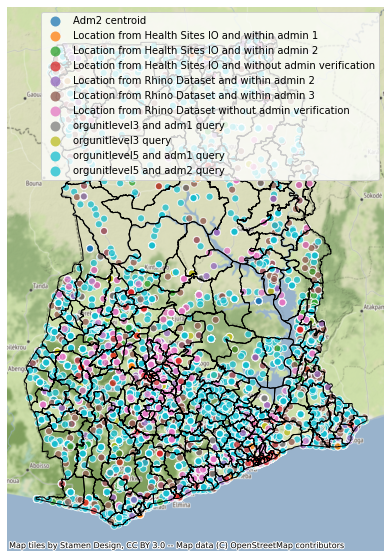

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
geob2.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from administrative polygons

Join admin data back to results.  
For adm2 features, use spatial join to geob2.  

In [143]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [ ]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [145]:
results2 = gpd.sjoin(results2, geob2[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [146]:
results2.rename(
    columns={
        'shapeName':'geob_adm2',
        'shapeID':'geob_adm2_id',
    }, inplace=True)

In [147]:
results2 = gpd.sjoin(results2, geob1[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [148]:
results2.geob_adm2.isna().sum(), results2.shapeName.isna().sum()

(0, 1)

In [149]:
results2.rename(
    columns={
        'shapeName':'geob_adm1',
        'shapeID':'geob_adm1_id',
        'adm1':'fuzzy_match_adm1',
        'adm2':'fuzzy_match_adm2'
    }, inplace=True)

In [113]:
#results2.to_file(join(output_dir, "GHA_geocoding_1.27.23.json"), driver='GeoJSON', index=True)

In [115]:
# results2

In [150]:
# FYI saving the results2, the results that were able to be geocoded
print(len(results))
print(len(results2))

10564
9677


In [151]:
results_final = pd.concat([results2, records_subset])
results_final.sort_index(inplace=True)
results_final.to_csv(join(output_dir, "GHA_geocoding_2.7.23.csv"))
results_final.to_file(join(output_dir, "GHA_geocoding_2.7.23.json"), driver="GeoJSON")